# The Visualization Script

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py

import io
import time
import glob
import fnmatch
from itertools import chain, cycle
from textwrap import dedent
from collections import defaultdict
from collections import OrderedDict as odict
from os.path import exists
from pandas.api.types import union_categoricals

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from bokeh.io import push_notebook, show, output_notebook, output_file, save
from bokeh.models import Band, ColumnDataSource
from bokeh.models import TapTool, Select, Div, BoxZoomTool, ResetTool
from bokeh.models import HoverTool, CustomJS, TabPanel, Tabs
from bokeh.plotting import figure 
from bokeh.layouts import gridplot, layout, row, column

In [ ]:
# This cell is a sorry attempt at integrating the code onto google colab.
# Feel free to remove this cell if you are not using google colab.

import os, sys, sysconfig
from importlib.util import find_spec
is_colab = 'google.colab' in sys.modules
site_userpkg = sysconfig.get_paths()['purelib']
if is_colab and (find_spec('ruamel') is None):
    ! pip install ruamel.yaml
if is_colab and not os.path.exists('/content/btspinn/'):
    ! cd /content && git clone https://github.com/ehsansaleh/btspinn.git
    ! cd /content/btspinn && pip install -e . && rm -rf *.egg-info
if is_colab and (find_spec('bspinn') is None):
    ! ln -s /content/btspinn/bspinn {site_userpkg}/bspinn
elif is_colab:
    ! [ -L {site_userpkg}/bspinn ] && rm {site_userpkg}/bspinn
if is_colab and os.path.exists('/content/btspinn/notebook'):
    os.chdir('/content/btspinn/notebook')

In [ ]:
import bspinn
from bspinn.io_utils import get_ovatgrps, drop_unqcols
from bspinn.io_cfg import configs_dir, results_dir
from bspinn.io_cfg import keyspecs, nullstr
from bspinn.io_utils import deep2hie, hie2deep
from bspinn.io_utils import save_h5data, load_h5data
from bspinn.io_utils import get_h5du, resio, get_dfidxs
from bspinn.summary import summarize

import yaml
from ruamel import yaml as ruyaml
from IPython import display as ICD

In [2]:
dflt_dashcfg = dict(xcol='epoch', ycol=None, huecol='fpidxgrp', 
    colsep=None, rngcol='rng_seed', frame_width=350, 
    frame_height=235, ncols=4, sharex=True, sharey=True, 
    header='Ablation Studies', menu_width=250, color_reset='figure',
    fig_title='Ablation: {ablname}', colors='snsdark', tooltip=None,
    y_axis_type='auto', y_tick_fmt=None, y_tick_lbls=None, 
    x_axis_type='auto', x_tick_fmt=None, x_tick_lbls=None)

#################################################
########### Aggregation of RNG Seeds ############
#################################################

def get_aggdf(hpdf, stdf, xcol, huecol, rngcol, agg='sem'):
    grphpdf = drop_unqcols(hpdf)
    if huecol not in grphpdf.columns:
        grphpdf.insert(0, huecol, hpdf[huecol])
    for col in grphpdf.columns:
        grphpdf[col] = grphpdf[col].tolist()
    grpstdf = stdf.copy()
    
    grpstdf = grpstdf.replace(nullstr, np.nan)

    stcols = [col for col in grpstdf.columns 
            if col not in (xcol, rngcol)]
    hpcols = list(grphpdf.columns)
    
    grpdf = pd.concat([grphpdf, grpstdf], axis=1)
    grpbycols = [huecol, xcol]

    if callable(agg):
        aggpolicy = {c: 'first' for c in hpcols}
        aggpolicy.update({c: agg for c in stcols})
        aggpolicy.pop(huecol, None)
        aggdf = grpdf.groupby(grpbycols, sort=False).agg(aggpolicy)
        aggcolsdict = odict()
        for col in stcols:
            pkg = tuple(zip(*(aggdf[col].tolist())))
            aggcolsdict[f'{col}/mean'] = pkg[0]
            aggcolsdict[f'{col}/low'] = pkg[1]
            aggcolsdict[f'{col}/high'] = pkg[2]
        aggdf = pd.concat([aggdf.reset_index().drop(columns=stcols), pd.DataFrame(aggcolsdict)], axis=1)
    elif agg in (None, 'mean', 'sem'):
        aggpolicy = {c: ['first'] for c in hpcols}
        aggpolicy.update({c: ['mean', 'sem'] for c in stcols})
        aggdf = grpdf.groupby(grpbycols, sort=False).agg(aggpolicy)
        for col in stcols:
            aggdf.loc[:, (col, 'low')] = aggdf[col]['mean'] - 1.96 * aggdf[col]['sem']
            aggdf.loc[:, (col, 'high')] = aggdf[col]['mean'] + 1.96 * aggdf[col]['sem']

        aggdf = aggdf.reindex(columns=hpcols+stcols, level=0)
        aggdf.columns = aggdf.columns.map('/'.join)
        aggdf = aggdf.reset_index().drop(columns=huecol)

        scc = [col for col in aggdf.columns if not col.endswith('/first')]
        aggdf = aggdf.rename(columns={f'{col}/first': col for col in hpcols})
        aggdf = aggdf[hpcols + scc]
    else:
        raise ValueError(f'error_band={error_band} not defined')
    
    outdict = dict(aggdf=aggdf, hpcols=hpcols, stcols=stcols)
    return outdict

class BStrapAgg:
    stat2func = {'mean': np.mean, 'median': np.median}

    def __init__(self, n_boot=20, q=(5, 95), 
        stat='mean', seed=12345):
        self.n_boot = n_boot
        self.q = q
        self.stat_f = self.stat2func[stat]
        self.np_random = np.random.RandomState(seed)

    def __call__(self, series):
        with np.errstate(invalid='ignore'):
            v = series.values
            n = v.size
            rsv = self.np_random.choice(v, self.n_boot*n, replace=True)
            x = rsv.reshape(self.n_boot, n)
            m = self.stat_f(x, axis=1)
            l = np.percentile(m, self.q[0])
            h = np.percentile(m, self.q[1])
            return (m.mean(), l, h)

#################################################
########### Dashboard Data & Building ###########
#################################################
def get_dflt_ablspec(hpdf, fpgrps, huecol='fpidxgrp', ablcol='ablgrp'):
    grpspec = []
    uhpdf = hpdf.drop_duplicates().copy()
    uhpdf = drop_unqcols(uhpdf.drop('fpidx', axis=1), exclist=[huecol])
    uhpdf = uhpdf.reset_index(drop=True)
    uhpidf = uhpdf.copy().set_index(huecol)
    for ii, fpidxs in enumerate(fpgrps):
        grphpdf = drop_unqcols(uhpidf.loc[fpidxs].reset_index(huecol))
        grpid = set(grphpdf.columns).difference({ablcol, huecol})
        grpid = sorted(grpid)
        grpspec.append(dict(name=', '.join(grpid), columns=[grpid]))
    return grpspec

def get_dashdata(data, ymlpath, write_yml=False,
    en_exclude=True, en_include=True):
    if exists(ymlpath):
        with open(ymlpath, 'r') as fp:
            dashconfig = ruyaml.load(fp, ruyaml.RoundTripLoader)
    else:
        dashconfig = dict()

    figspec = dashconfig.setdefault('figures', dict())
    aggcfg = dashconfig.setdefault('aggregate', dict())
    dropcfg = dashconfig.setdefault('drop', dict())
    renamecfg = dashconfig.setdefault('rename', dict())
    plotcfg = dashconfig.setdefault('plot', dict())

    #################################################
    ############### Aggregator Setup ################
    #################################################
    aggtype = aggcfg.setdefault('type', 'mean')
    if aggtype == 'bootstrap':
        n_boot = aggcfg.setdefault('n_boot', 20)
        q = aggcfg.setdefault('q', [5, 95])
        stat = aggcfg.setdefault('stat', 'mean')
        aggregator = BStrapAgg(n_boot=n_boot, q=q, stat=stat, seed=12345)
        assert len(aggcfg) == 4
    elif aggtype in ('sem', 'mean'):
        aggregator = 'sem'
        assert len(aggcfg) == 1
    else:
        raise ValueError(f'aggregation type={aggtype} not defined')

    #################################################
    ########### Column Definition Options ###########
    #################################################
    drop_colpats = dropcfg.setdefault('columns', [])
    assert len(dropcfg) == 1

    col_renamer = renamecfg.setdefault('columns', dict())
    col_replacer = renamecfg.setdefault('colrplc', dict())
    assert len(renamecfg) == 2
    
    for opt, dfltoptval in dflt_dashcfg.items():
        optval = plotcfg.get(opt, dfltoptval)
        if opt.endswith('col'):
            optval = col_renamer.get(optval, optval)
            if isinstance(optval, str):
                for kk, vv in col_replacer.items():
                    optval = optval.replace(kk, vv)
        plotcfg[opt] = optval
    assert len(plotcfg) == len(dflt_dashcfg), plotcfg

    xcol = plotcfg['xcol']
    huecol = plotcfg['huecol']
    rngcol = plotcfg['rngcol']
    
    #################################################
    ################ Data Processing ################
    #################################################
    dashdata = []
    for method, hpdf, stdf in data:
        meth_ablspec = figspec.setdefault(method, list())

        # Getting a copy of the input dataframes
        hpdf, stdf = hpdf.copy(), stdf.copy()

        # Dropping some stat columns
        if drop_colpats is not None:
            stdfcols = stdf.columns.tolist()
            drop_cols = chain.from_iterable(fnmatch.filter(stdfcols, pat) 
                for pat in drop_colpats)
            stdf = stdf.drop(columns=drop_cols)

        # Shortening the fpidx and fpidxgrp columns to save space on html
        hpdf['fpidx'] = hpdf['fpidx'].cat.codes
        hpdf[huecol] = hpdf[huecol].cat.codes

        # Renaming the columns
        if col_renamer is not None:
            stdf = stdf.rename(columns=col_renamer)
        if col_replacer is not None:
            colsrplcd = dict()
            for col in stdf.columns.tolist():
                colrp = col
                for kk, vv in col_replacer.items():
                    colrp = colrp.replace(kk, vv)
                colsrplcd[col] = colrp
            stdf = stdf.rename(columns=colsrplcd)

        # Grouping the hyper-parameters 
        fpgrps = get_ovatgrps(hpdf)
        dfltabldefs = get_dflt_ablspec(hpdf, fpgrps, huecol, 'ablgrp')
        grphpcols = [tuple(x['columns'][0]) for x in dfltabldefs]
        hpcols2fpgrp = dict(zip(grphpcols, fpgrps))
        
        # Adding existing ablations that do not exist in
        # the ablation config file
        mcols = [l['columns'] for l in meth_ablspec]
        mcols = [x if x != '*' else grphpcols for x in mcols]
        mohpc = chain.from_iterable(mcols)
        mohpc = [tuple(sorted(x)) for x in mohpc]
        try:
            used_fpgrpidxs = set(chain.from_iterable(hpcols2fpgrp[x] for x in mohpc))
        except Exception as exc:
            globals().update(locals())
            raise exc
        for fpgrp, abldict in zip(fpgrps, dfltabldefs):
            if any(fpgrpidx not in used_fpgrpidxs for fpgrpidx in fpgrp):
                meth_ablspec.append(abldict)

        # Adding the method column
        hpdf.insert(0, 'method', method)

        # Adding the ablation group column
        hpdfgrp_list, stdfgrp_list = [], []
        abl2mpldict = dict()
        for abldict in meth_ablspec:
            ablname = abldict['name']
            exclist = abldict.get('exclude', [])
            exclist = exclist if en_exclude else []
            inclist = abldict.get('include', [])
            inclist = inclist if en_include else []
            abl2mpldict[ablname] = abldict.get('matplotlib', None)
            allhpcols = abldict['columns'] if (abldict['columns'] != '*') else grphpcols
            for hpcols in allhpcols:
                fpgrp = hpcols2fpgrp[tuple(sorted(hpcols))]
                ii = hpdf[huecol].isin(fpgrp)
                if len(exclist) > 0:
                    exc_il = [get_dfidxs(hpdf, excdict) for excdict in exclist]
                    jj = np.stack(exc_il, axis=1).any(axis=1)
                    ii = np.logical_and(ii, np.logical_not(jj))
                if len(inclist) > 0:
                    inc_il = [get_dfidxs(hpdf, incdict) for incdict in inclist]
                    jj = np.stack(inc_il, axis=1).any(axis=1)
                    ii = np.logical_and(ii, jj)
                hpdfgrp = hpdf[ii].copy()
                stdfgrp = stdf[ii]
                hpdfgrp.insert(1, 'ablgrp', ablname)
                hpdfgrp_list.append(hpdfgrp)
                stdfgrp_list.append(stdfgrp)
        hpdf = pd.concat(hpdfgrp_list, axis=0, ignore_index=True)
        stdf = pd.concat(stdfgrp_list, axis=0, ignore_index=True)

        hpdf = hpdf.fillna(nullstr)
        stdf = stdf.fillna(nullstr)

        hpdf, stdf = hpdf, stdf
        for fig_idx, (ablname, ablhpdf) in enumerate(hpdf.groupby('ablgrp', sort=False)):
            ablstdf = stdf.loc[ablhpdf.index.values]
            aggdict = get_aggdf(ablhpdf, ablstdf, xcol, huecol, rngcol, aggregator)
            aggdf, hpcols, stcols = aggdict['aggdf'], aggdict['hpcols'], aggdict['stcols']
            mpldict = abl2mpldict[ablname]
            dashdata.append((method, ablname, aggdf, hpcols, stcols, mpldict))

    if write_yml: 
        if exists(ymlpath):
            with open(ymlpath, 'w') as fp:
                ruyaml.dump(dashconfig, fp, ruyaml.RoundTripDumper)
        else:
            with open(ymlpath, 'w') as fp:
                yaml.dump(dashconfig, fp, sort_keys=False, default_flow_style=None)

    outdict = dict(plotcfg)
    outdict['data'] = dashdata
    outdict.pop('rngcol', None)
    return outdict

def build_dashboard(doc, data, xcol, ycol, header,
    huecol, fig_title, colors=None, frame_width=350, 
    frame_height=235, ncols=4, sharex=True, sharey=True, 
    tooltip=None, menu_width=150, colsep=None, color_reset='figure',
    y_axis_type='auto', y_tick_fmt=None, y_tick_lbls=None, 
    x_axis_type='auto', x_tick_fmt=None, x_tick_lbls=None):

    if colors in (None, 'snsdark'):
        colors = ['#001c7f', '#b1400d', '#12711c', '#8c0800', '#591e71', 
                  '#592f0d', '#a23582', '#3c3c3c', '#b8850a', '#006374']
    else:
        assert isinstance(colors, list)

    if fig_title is None:
        fig_title = 'Ablation: {ablname}'

    all_bkfigdata = []
    all_tabbkfigdata = []
    tabs_list = []

    tab2data = odict()
    for tabname, ablname, aggdf, hpcols, stcols, mpldict in data:
        figsdata = tab2data.setdefault(tabname, [])
        figsdata.append((ablname, aggdf, hpcols, stcols))
        if ycol is None:
            ycol = [c[:-5] for c in aggdf.columns 
                if c.endswith('/mean')][-1]
    assert ycol is not None
    assert sharex in (True, False, 'tab', 'all', 'none')
    assert sharey in (True, False, 'tab', 'all', 'none')
    assert color_reset in ('figure', 'tab', 'all')
    if color_reset == 'all':
        colors_cycle = cycle(colors)
    for tabname, figsdata in tab2data.items():
        n_tabfig = len(figsdata)
        n_rows = int(np.ceil(n_tabfig / ncols))
        screen_width = int(frame_width*(ncols+0.1))
        screen_hight = int(frame_height*(n_rows+0.1))
        tab_bkfigdata = []

        if color_reset == 'tab':
            colors_cycle = cycle(colors)
        for fig_idx, (ablname, aggdf, hpcols, stcols) in enumerate(figsdata):
            ax_row, ax_col = fig_idx // ncols, fig_idx % ncols
            idcols = [col for col in hpcols if col not in ('fpidx', huecol)]
            if tooltip is not None:
                idcols += tooltip

            show_xaxis = (sharex in (False, 'none')) or (ax_row == (n_rows-1))
            show_yaxis = (sharey in (False, 'none')) or (ax_col == 0)

            zoomtool = BoxZoomTool()
            figtools = [zoomtool, 'reset,pan,wheel_zoom']
            
            hover_opts = dict(show_arrow=False,
                line_policy='next', mode='mouse', toggleable=False)
            
            figure_opts = dict(y_axis_type=y_axis_type, 
                x_axis_type=x_axis_type, frame_height=frame_height, 
                frame_width=frame_width, sizing_mode='inherit')
            
            fig = figure(**figure_opts, tools=figtools)
            fig.toolbar.active_drag = zoomtool

            source_list = []
            fpidf_list = []
            if color_reset == 'figure':
                colors_cycle = cycle(colors)
            for lineidx, (fpidx, fpidf) in enumerate(aggdf.groupby(huecol, sort=False)):
                color = next(colors_cycle)
                fpidf = fpidf.copy()

                fpidf = fpidf.set_index(xcol)
                fpidf = fpidf.replace(np.inf, np.nan)
                fpidf = fpidf.interpolate(method='index', limit_direction='both')
                fpidf = fpidf.reset_index()

                for col in fpidf.columns:
                    if fpidf[col].dtype == 'bool':
                        fpidf[col] = fpidf[col].astype(str)

                fpidf['y/mean'] = fpidf[f'{ycol}/mean']
                fpidf['y/low'] = fpidf[f'{ycol}/low']
                fpidf['y/high'] = fpidf[f'{ycol}/high']
                
                source = ColumnDataSource(fpidf)
                line = fig.line(x=xcol, y=f'y/mean', source=source,  
                    legend_label=str(fpidx), color=color, line_width=5)

                tooltip_tups = [(col, '@{'+col+'}') for col in idcols 
                    if not (fpidf[col] == nullstr).values.all()]
                if len(tooltip_tups) > 0:
                    fig.add_tools(HoverTool(renderers=[line], 
                        tooltips=tooltip_tups, **hover_opts))
                
                band = Band(base=xcol, lower=f'y/low', 
                    upper=f'y/high', source=source,
                    fill_alpha=0.3, fill_color=color)
                fig.add_layout(band)
                source_list.append(source)
                fpidf_list.append(fpidf)

            fontsize = "10pt"
            if show_xaxis:
                fig.xaxis.axis_label = xcol
                fig.xaxis.axis_label_text_font_size = fontsize
                fig.xaxis.major_label_text_font_size = fontsize
                fig.xaxis.axis_label_text_color = "black"
            else:
                fig.xaxis.visible = False

            if show_yaxis:
                ycol_ = ycol if len(ycol) <= 50 else ycol.split(colsep)[0]
                fig.yaxis.axis_label = ycol_
                fig.yaxis.axis_label_text_font_size = fontsize
                fig.yaxis.major_label_text_font_size = fontsize
                fig.yaxis.axis_label_text_color = "black"
            else:
                fig.yaxis.visible = False

            fig.title.text = fig_title.format(ablname=ablname) 
            fig.legend.visible = False 
            fig.legend.destroy()

            for tick_fmt, tick_lbls, axis in [(x_tick_fmt, x_tick_lbls, fig.xaxis),
                                              (y_tick_fmt, y_tick_lbls, fig.yaxis)]:
                if tick_lbls is not None:
                    axis.ticker = tick_lbls
                if tick_fmt == 'eng':
                    msg_ = f'for eng fmt, tick labels must be specified'
                    assert tick_lbls is not None, msg_
                    mpleng = EngFormatter()
                    engfmtr = lambda n: mpleng.format_eng(n).replace(' ', '')
                    axis.major_label_overrides = {x: engfmtr(x) for x in tick_lbls}
                else:   
                    assert tick_fmt in ('eng', None)
            
            fig.outline_line_color = 'black'
            fig.min_border = 10

            figdict=dict(fig=fig, source_list=source_list, fpidf_list=fpidf_list)
            tab_bkfigdata.append(figdict)

        all_bkfigdata += tab_bkfigdata
        all_tabbkfigdata.append(tab_bkfigdata)
        tab_figs = [x['fig'] for x in tab_bkfigdata]
        gridfigs = gridplot(tab_figs, ncols=ncols, sizing_mode='inherit')
        tabpanel = TabPanel(child=gridfigs, title=tabname, closable=True)
        tabs_list.append(tabpanel)
    
    tabgridfigs = Tabs(tabs=tabs_list, sizing_mode='inherit')
    all_figs = [x['fig'] for x in all_bkfigdata]
    all_tabfigs = [[x['fig'] for x in tab_bkfigdata] for tab_bkfigdata in all_tabbkfigdata]
    
    if sharey in (True, 'all'):
        for fig in all_figs:
            fig.y_range = all_figs[0].y_range
    elif sharey == 'tab':
        for tabfigs in all_tabfigs:
            for fig in tabfigs:
                fig.y_range = tabfigs[0].y_range
    elif sharey in (False, 'none'):
        pass
    else:
        raise ValueError(f'sharey={sharey} not defined')
    
    if sharex in (True, 'all'):
        for fig in all_figs:
            fig.x_range = all_figs[0].x_range
    elif sharex == 'tab':
        for tabfigs in all_tabfigs:
            for fig in tabfigs:
                fig.x_range = tabfigs[0].x_range
    elif sharex in (False, 'none'):
        pass
    else:
        raise ValueError(f'sharex={sharex} not defined')

    # Menu update callback in javascript
    code_js = """
        ////////////////////////////////////////////////////
        ///////////////// Menu Separation //////////////////
        ////////////////////////////////////////////////////
        var opts, menu, val;
        var ccd = cdeep;
        var sects = sectscds.data["sects"];
        for (let i=0; i < n_menu; i++) {
            if (i <= menu_idx) {
                if (i < menu_idx) {
                    val = sects[i];
                } else {
                    val = right_menus[0].value;
                    sects[i] = val;
                }
                ccd = ccd[val];
            } else {
                menu = right_menus[i-menu_idx];
                if (ccd == null) {
                    val = null;
                    menu.visible = false;
                    menu.options = [];
                } else {
                    opts = Object.keys(ccd);
                    if (opts.includes(sects[i])) {
                        val = sects[i];
                    } else {
                        val = opts[0];
                    }
                    ccd = ccd[val];
                    menu.visible = true;
                    menu.options = opts;
                    menu.value = val;
                }
                sects[i] = val;
            }

        }
        // The new axis
        var ycol_new = sects.filter(Boolean).join(colsep);
        
        ////////////////////////////////////////////////////
        ////////////////// Source Update ///////////////////
        ////////////////////////////////////////////////////
        // var ycol_new = cb_obj.value;
        const statnames = ["mean", "low", "high"];
        for (let j=0; j<all_srcs.length; j++) {
            var sdata = all_srcs[j].data;
            for (let k=0; k< statnames.length; k++) {
                var stn = statnames[k];
                var ycol_stn = ycol_new.concat(colsep, stn);
                var y_stn = "y".concat(colsep, stn);
                sdata[y_stn] = [];
                if (ycol_stn in sdata) {
                    for (let i=0;i<sdata[ycol_stn].length; i++) {
                        sdata[y_stn].push(sdata[ycol_stn][i]);
                    }
                }
            }
        }

        for (let j=0; j<all_srcs.length; j++) {
            all_srcs[j].change.emit();
        }

        var axlbl = ycol_new;
        if (axlbl.length > 50) {
            axlbl = axlbl.split(colsep)[0];
        }
        for (let j=0; j<all_yaxes.length; j++) {
            all_yaxes[j].axis_label = axlbl;
        }
    """
    # Creating Menus and seperating the columns
    if colsep is None:
        colsep = '######'
    cdeep = hie2deep({c: None for c in stcols}, sep=colsep)
    n_menu = max(c.count(colsep) for c in stcols) + 1
    sects = ycol.split(colsep)
    sects += (n_menu - len(sects)) * [None]
    all_menus = []
    dd = cdeep
    for i in range(n_menu):
        sect = sects[i]
        assert (dd is None) == (sect is None)
        opts = [] if sect is None else list(dd.keys())
        ddd = dict(title='Y-Axis') if i == 0 else dict(title="      ")
        menu = Select(options=opts, value=sect, **ddd,
            width=menu_width, height=50, sizing_mode='fixed')
        if sect is None:
            menu.visible = False
        menu.align = 'end'
        if dd is not None:
            dd = dd[sect]
        all_menus.append(menu)

    sectscds = ColumnDataSource(data={'sects': sects})
    all_srcs = list(chain.from_iterable(figdata['source_list'] 
        for figdata in all_bkfigdata))
    all_yaxes = [fig.yaxis[0] for fig in all_figs]

    for menu_idx, menu in enumerate(all_menus):
        menu_args = dict(cdeep=cdeep, n_menu=n_menu, 
            menu_idx=menu_idx, right_menus=all_menus[menu_idx:], 
            sectscds=sectscds, colsep=colsep)
        data_args = dict(all_srcs=all_srcs, all_figs=all_figs, 
            all_yaxes=all_yaxes)
        jscb = CustomJS(args={**menu_args, **data_args}, code=code_js)
        menu.js_on_change('value', jscb)
    
    # heading fills available width
    heading = Div(text=f'<h1 style="text-align: center">{header}</h1>', 
        width=screen_width-menu_width*n_menu, height=50, 
        sizing_mode='stretch_width')
    
    fulllayout = column(row(heading, *all_menus, sizing_mode='stretch_width'), 
        tabgridfigs, sizing_mode='stretch_both')
    
    if doc is not None:
        doc.add_root(fulllayout)
    else:
        return fulllayout

def draw_matplotlib(mpldict, aggdf):
    figsize = mpldict['figsize']
    xcol = mpldict['xcol']
    ycol = mpldict['ycol']
    pltkind = mpldict['kind']
    selcol = mpldict.get('smry/sel', None) 
    smrycri = mpldict.get('smry/cri', None)
    colorspec = mpldict.get('colorspec', dict())
    xlabel = mpldict.get('xlabel', None)
    ylabel = mpldict.get('ylabel', None)
    ylim = mpldict.get('ylim', None)
    xlim = mpldict.get('xlim', None)
    yscale = mpldict.get('yscale', None)
    xscale = mpldict.get('xscale', None)
    yticks = mpldict.get('yticks', None)
    xticks = mpldict.get('xticks', None)
    yticklabels = mpldict.get('yticklabels', None)
    xticklabels = mpldict.get('xticklabels', None)
    ylabelpad = mpldict.get('ylabelpad', None)
    xlabelpad = mpldict.get('xlabelpad', None)
    fig, ax = mpldict.get('fig', None), mpldict.get('ax', None)
    mpldeep = hie2deep(mpldict, dict, 1)

    plot_or_bar = 'ax.plot' if pltkind == 'line' else 'ax.bar'
    apkwg = mpldeep.get(plot_or_bar, dict())
    akg = mpldeep.get('ax.annotate', dict())
    apg = mpldeep.get('arrowprops', dict())
    bbg = mpldeep.get('bbox', dict())

    if ax is None:
        assert fig is None
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=100)
    else:
        assert fig is not None
    aggdf = aggdf.copy(deep=True)

    if selcol is not None:
        grpobj = aggdf.groupby('fpidxgrp')[selcol]
        assert smrycri in ('min', 'max')
        smrlocs = grpobj.idxmin() if smrycri == 'min' else grpobj.idxmax()
        smrydf = aggdf.loc[smrlocs].reset_index(drop=True)
    else:
        smrydf = aggdf
    n_smrrows = smrydf.shape[0]

    lbl2ap = dict()
    lbl2bb = dict()
    lbl2akw = dict()
    lbl2pkw = dict()
    for i_lbl, (lbl, props) in enumerate(mpldict['elements'].items()):
        apl = hie2deep(props, dict, 1).get('arrowprops', dict())
        bbl = hie2deep(props, dict, 1).get('bbox', dict(facecolor='none', edgecolor= 'none'))
        akl = hie2deep(props, dict, 1).get('ax.annotate', dict())
        
        apkwl = hie2deep(props, dict, 1).get(plot_or_bar, dict())
        annotkws = {**akg, **akl}
        arrowprops = {**apg, **apl}
        bbox = {**bbg, **bbl}
        plotkws = {**apkwg, **apkwl}
        exclist = props.get('exclude', [])
        inclist = props.get('include', [])
        ii = np.array([True] * n_smrrows)
        if len(exclist) > 0:
            exc_il = [get_dfidxs(smrydf, excdict) for excdict in exclist]
            jj = np.stack(exc_il, axis=1).any(axis=1)
            ii = np.logical_and(ii, np.logical_not(jj))
        if len(inclist) > 0:
            inc_il = [get_dfidxs(smrydf, incdict) for incdict in inclist]
            jj = np.stack(inc_il, axis=1).any(axis=1)
            ii = np.logical_and(ii, jj)
        smrydf.loc[ii, 'label'] = lbl
        smrydf.loc[ii, 'x'] = i_lbl
        lbl2pkw[lbl] = plotkws
        lbl2akw[lbl] = annotkws
        lbl2ap[lbl] = arrowprops
        lbl2bb[lbl] = bbox

    smrydf = smrydf[~smrydf['label'].isnull()]

    if pltkind == 'line':
        for label, lbldf in smrydf.groupby('label'):
            lbldf2 = lbldf.sort_values(by=[xcol])
            plotkws = lbl2pkw[label].copy()
            color = plotkws.pop('color', None)
            color = colorspec.get(color, color)
            ax.plot(lbldf2[xcol], lbldf2[f'{ycol}/mean'], 
                color=color, label=label, **plotkws)
            ax.fill_between(lbldf2[xcol], lbldf2[f'{ycol}/low'], 
                lbldf2[f'{ycol}/high'], color=color, alpha=0.2)
    elif pltkind == 'bar':
        # Computing the error bar sizes: err = [mean - low, high - mean]
        yerr = smrydf[[f'{ycol}/low', f'{ycol}/high']].values.T
        yerr = yerr - smrydf[f'{ycol}/mean'].values.reshape(1, -1)
        yerr = yerr * np.array([[-1], [1]])

        x_ticks_, x_ticklabels_ = [], []
        for i_row, row in smrydf.reset_index(drop=True).iterrows():
            label = row['label']
            plotkws = lbl2pkw[label].copy()
            color = plotkws.pop('color', None)
            color = colorspec.get(color, color)
            x_tick, x_ticklabel = row['x'], row['label']
            ax.bar(x=x_tick, height=row[f'{ycol}/mean'], color=color,
                tick_label=x_ticklabel, yerr=yerr[:, (i_row):(i_row+1)], 
                **plotkws)
            x_ticks_.append(x_tick)
            x_ticklabels_.append(x_ticklabel)
        ax.set_xticks(x_ticks_)
        ax.set_xticklabels(x_ticklabels_)

    if xlabel is not None: ax.set_xlabel(xlabel, labelpad=xlabelpad)
    if ylabel is not None: ax.set_ylabel(ylabel, labelpad=ylabelpad)
    if ylim is not None: ax.set_ylim(*ylim)
    if yscale is not None: ax.set_yscale(yscale)
    if xlim is not None: ax.set_xlim(*xlim)
    if xscale is not None: ax.set_xscale(xscale)
    if yticks is not None: ax.set_yticks(yticks)
    if yticklabels is not None: ax.set_yticklabels(yticklabels)
    if xticks is not None: ax.set_xticks(xticks)
    if xticklabels is not None: ax.set_xticklabels(xticklabels)

    ax2data = ax.transAxes + ax.transData.inverted()
    data2ax = ax2data.inverted()
    for label, lbldf in smrydf.groupby('label'):
        row = lbldf.iloc[0]
        annotkws = lbl2akw[label].copy()
        text = annotkws.pop('text', None)
        xytext = annotkws.pop('xytext', None)
        label = row['label']
        if text is None: continue
        
        # The top of the bar in data coordinates
        arrowpos_x, arrowpos_y = annotkws.pop('xy', (None, None))
        xycoords = annotkws.get('xycoords', None)
        assert (xycoords == 'axes fraction'), 'not implemented yet'
        if pltkind == 'bar':
            assert arrowpos_x is None
            assert arrowpos_y is None
            xy_posdata = row['x'], row[f'{ycol}/mean']
            xy_posfrac = data2ax.transform(xy_posdata)
        elif pltkind == 'line':
            assert (xycoords == 'axes fraction'), 'not implemented yet'
            xy_posxdata = ax2data.transform([arrowpos_x, 0.0])[0]
            xy_posydata = arrowpos_y
            if xy_posydata is None:
                lbldf2 = lbldf.sort_values(by=[xcol])
                from scipy.interpolate import interp1d
                fi = interp1d(lbldf2[xcol], lbldf2[f'{ycol}/mean'], 
                    fill_value='extrapolate')
                assert arrowpos_x is not None
                xy_posydata = fi(xy_posxdata).item()
                assert xy_posydata is not None
            xy_posdata = xy_posxdata, xy_posydata
            xy_posfrac = data2ax.transform(xy_posdata)
        else: 
            raise ValueError(f'pltkind={pltkind} undefined')
        
        if (xycoords == 'axes fraction'): xy = xy_posfrac 
        elif (xycoords == 'data'): xy = xy_posdata 
        else: raise ValueError(f'xycoords={xycoords} undefined')

        ax.annotate(xy=xy, xytext=xytext, text=text,
            arrowprops=lbl2ap[label], bbox=lbl2bb[label], **annotkws)
    return fig, ax


All the generated dashboards and figures will be housed under the `notebook/26_plotting` directory.

In [3]:
workdir = '29_plotting'
! mkdir -p {workdir}

suppdir = f'{workdir}/supplement'
! mkdir -p {suppdir}

# The High Dimensional Poisson Problem

## The Main Study

### The Training Curves Dashboard

The generated dashboard is `35_poisshidim.html`.

Relevant configs are `01_poisson/21_hindim.json` and `01_poisson/26_hindim.json`. 

These were the results for all of the methods on all of the dimensions in the the Poisson problem.

In [8]:
smrypath = f'../summary/11_poisshidim.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
hpdf = data['hp']
statdf = data['stat']

ymlpath = f'{workdir}/34_poisshidim.yml'
all_dims = sorted(hpdf['dim'].unique().tolist())
data = []
for dim in all_dims:
    didx = (hpdf['dim'] == dim)
    dhpdf = hpdf.loc[didx, :].reset_index(drop=True)
    dstdf = statdf.loc[didx, :].reset_index(drop=True)
    data.append((f'{dim}-Dimensional', dhpdf, dstdf))
dashdata = get_dashdata(data, ymlpath, write_yml=False)

fulllayout = build_dashboard(None, **dashdata)
output_file(f'{workdir}/35_poisshidim.html')
save(fulllayout, title=dashdata['header'])

Disk usage for "../summary/11_poisshidim.h5"
hp                                                                              134.740 MB
stat                                                                           1966.358 MB
------------------------------------------------------------------------------------------
Total                                                                             2.101 GB


'/shared-mounts/sinhas/Saba/code_bspinn/notebook/25_plotting/35_poisshidim.html'

### The MSE vs the Problem Dimension Figure

The generated figure is named `37_mse_vs_dim_hdp.pdf` and is the same as Figure 4 of the main paper.

Relevant model training configs are `01_poisson/21_hindim.json` and `01_poisson/26_hindim.json`. 

This part draws the high-dim poisson figure in the main paper, and uses the same data as the `35_poisshidim.html` dashboard.

In [9]:
smrypath = f'../summary/11_poisshidim.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
hpdf = data['hp']
statdf = data['stat']

hpdf = hpdf.sort_values(by=['dim', 'trg/btstrp', 'srfpts/dblsmpl', 'vol/n'])
i1 = hpdf.index.values
hpdf = hpdf.reset_index(drop=True)
statdf = statdf.loc[i1, :].reset_index(drop=True)

ymlpath = f'{workdir}/36_poisshidim.yml'
data = [('Main',  hpdf,      statdf)]
dashdata = get_dashdata(data, ymlpath, write_yml=False)

Disk usage for "../summary/11_poisshidim.h5"
hp                                                                              134.740 MB
stat                                                                           1966.358 MB
------------------------------------------------------------------------------------------
Total                                                                             2.101 GB


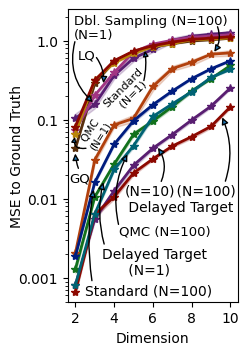

In [18]:
mplglbls = ruyaml.safe_load("""
  ycol: Performance/Deterministic/Train Volumes 3/Main/Normalized/MSE
  figsize: [2.2, 3.8]
  smry/sel: Performance/Deterministic/Train Volumes 3/Main/Normalized/MSE/mean
  smry/cri: min
  colorspec: 
    blue: '#001c7f'
    orange: '#b1400d'
    green: '#12711c'
    red: '#8c0800'
    purple: '#591e71'
    brown: '#592f0d'
    pink: '#a23582'
    gray: '#3c3c3c'
    yellow: '#b8850a'
    cyan: '#006374'
    black: '#000000'
  yscale: log
  xlabel: Dimension
  ylabel: MSE to Ground Truth
  ax.plot/marker: '*'
  ax.plot/lw: 2
  arrowprops/arrowstyle: "-|>"
  ax.annotate/xycoords: axes fraction 
  ax.annotate/textcoords: axes fraction
  ylim: [5e-4, 2.5e0]
  yticks: [0.001, 0.01, 0.1, 1.]
  yticklabels: ['0.001', '0.01', '0.1', '1.0']
  xticks: [2, 4, 6, 8, 10]
  ylabelpad: -4
""")


mpldict = yaml.safe_load("""
kind: line
xcol: dim
elements:
  Delayed Target (N=100):
    include: [{trg/w: 0.99, srfpts/n/trg: 50, srfpts/n/mdl: 51, trg/btstrp: true}]
    ax.plot/color: red
    ax.annotate/text: "            (N=100)\\n Delayed Target"
    ax.annotate/xytext: [0.33, 0.31]
    ax.annotate/xy: [0.9, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.9, 1.0]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  Delayed Target (N=10):
    include: [{trg/w: 0.996, srfpts/n/trg: 5, srfpts/n/mdl: 6, trg/btstrp: true}]
    ax.plot/color: purple
    ax.annotate/text: "(N=10)"
    ax.annotate/xytext: [0.335, 0.365]
    ax.annotate/xy: [0.52, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.7, 1.0]
    arrowprops/connectionstyle: "arc3,rad=0.3"
  Delayed Target (N=1):
    include: [{trg/w: 0.998, srfpts/n/mdl: 1, srfpts/n/trg: 1, trg/btstrp: true}]
    ax.plot/color: green
    ax.annotate/text: "Delayed Target\\n      (N=1)"
    ax.annotate/xytext: [0.20, 0.095]
    ax.annotate/xy: [0.22, null]
    bbox/pad: 100
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkB: 5
    arrowprops/relpos: [0.03, 1.0]
    arrowprops/connectionstyle: "arc3,rad=-0.15"
  Standard (N=100):
    include: [{srfpts/n/trg: 100}]
    exclude: [{trg/btstrp: true}, {srfpts/dblsmpl: true}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=100)"
    ax.annotate/xytext: [0.1, 0.025]
    ax.annotate/xy: [0.17, null]
    bbox/pad: 120
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkB: 10.0
    arrowprops/relpos: [0.06, 1.0]
    arrowprops/connectionstyle: "arc3,rad=-0.1"
  Standard (N=1):
    include: [{srfpts/n/trg: 1}]
    exclude: [{trg/btstrp: true}, {srfpts/dblsmpl: true}]
    ax.plot/color: red
    ax.annotate/text: "Standard\\n   (N=1)"
    ax.annotate/xytext: [0.20, 0.64]
    ax.annotate/xy: [0.45, null]
    ax.annotate/rotation: 45
    ax.annotate/fontsize: 8.0
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.82, 0.7]
    arrowprops/shrinkA: 0
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.1"
  Double Sampling (N=100):
    include: [{srfpts/n/trg: 100, srfpts/dblsmpl: true}]
    ax.plot/color: orange
    ax.annotate/text: "Dbl. Sampling (N=100)"
    ax.annotate/xytext: [0.035, 0.95]
    ax.annotate/fontsize: 9.5
    ax.annotate/xy: [0.85, null]
    bbox/pad: 100
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.93, 0.2]
    arrowprops/connectionstyle: "arc3,rad=-0.3"
  Double Sampling (N=1):
    include: [{srfpts/n/trg: 2, srfpts/dblsmpl: true}]
    ax.plot/color: purple
    ax.annotate/text: "(N=1)"
    ax.annotate/xytext: [0.035, 0.90]
    ax.annotate/xy: [0.16, null]
    ax.annotate/fontsize: 9.5
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.05, 0.18]
    arrowprops/connectionstyle: "arc3,rad=0.32"
  Gaussian Quadrature:
    include: [{srfpts/trnsfrm/dstr: cube2sphr, srfpts/samp/dstr: quad, 
               srfpts/samp/order: 2, srfpts/samp/rule: gaussian, 
               srfpts/samp/sparse: true, srfpts/samp/rcuralg: stieltjes}]
    ax.plot/color: brown
    ax.annotate/text: "GQ"
    ax.annotate/xytext: [0.01, 0.41]
    ax.annotate/xy: [0.044, null]
    ax.annotate/fontsize: 9.5
    ax.annotate/rotation: 0
    bbox/pad: -10
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.5, 1.0]
    arrowprops/connectionstyle: "arc3,rad=-0.1"
  Leja Quadrature:
    include: [{srfpts/trnsfrm/dstr: cube2sphr, srfpts/samp/dstr: quad, 
               srfpts/samp/order: 2, srfpts/samp/rule: leja, 
               srfpts/samp/sparse: true, srfpts/samp/rcuralg: stieltjes}]
    ax.plot/color: pink
    ax.annotate/text: "LQ"
    ax.annotate/xytext: [0.06, 0.83]
    ax.annotate/xy: [0.21, null]
    ax.annotate/fontsize: 9.5
    ax.annotate/rotation: 0
    bbox/pad: -10
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkB: 0
    arrowprops/relpos: [0.95, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  QMC (N=1):
    include: [{srfpts/trnsfrm/dstr: cube2sphr, srfpts/samp/dstr: qmc, 
               srfpts/samp/rule: additive_recursion, srfpts/n/trg: 1}]
    ax.plot/color: yellow
    ax.annotate/text: " QMC\\n(N=1)"
    ax.annotate/xytext: [0.06, 0.52]
    ax.annotate/xy: [0.045, null]
    ax.annotate/fontsize: 7.5
    ax.annotate/rotation: 58
    bbox/pad: 100
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.31, 0.10]
    arrowprops/connectionstyle: "arc3,rad=-0.8"
  QMC (N=100):
    include: [{srfpts/trnsfrm/dstr: cube2sphr, srfpts/samp/dstr: qmc, 
               srfpts/samp/rule: additive_recursion, srfpts/n/trg: 100}]
    ax.plot/color: cyan
    ax.annotate/text: "QMC (N=100)"
    ax.annotate/xytext: [0.3, 0.23]
    ax.annotate/xy: [0.37, null]
    ax.annotate/fontsize: 9.5
    ax.annotate/rotation: 0
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkA: -1.
    arrowprops/shrinkB: 5
    arrowprops/relpos: [0.0, 0.9]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata['data'][0]
fig, ax = draw_matplotlib({**mplglbls, **mpldict}, aggdf)

In [19]:
fig.savefig(f'{workdir}/37_mse_vs_dim_hdp.pdf', bbox_inches="tight")

## The Sample Size Study for the Delayed Target Method

### The Training Curves Dashboard

The generated dashboard is named `47_poisshidim.html`

The relevant model training configs are `01_poisson/27_hindim.json`. 

These are the results for the 5-fold increase in `N` for both the standard and the delayed target method variants.

In [4]:
smrypath = f'../summary/15_poisshidim.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
hpdf = data['hp']
statdf = data['stat']

ymlpath = f'{workdir}/46_poisshidim.yml'
all_dims = sorted(hpdf['dim'].unique().tolist())
data = []
for dim in all_dims:
    didx = (hpdf['dim'] == dim)
    dhpdf = hpdf.loc[didx, :].reset_index(drop=True)
    dstdf = statdf.loc[didx, :].reset_index(drop=True)
    data.append((f'{dim}-Dimensional', dhpdf, dstdf))
dashdata = get_dashdata(data, ymlpath, write_yml=False)

fulllayout = build_dashboard(None, **dashdata)
output_file(f'{workdir}/47_poisshidim.html')
save(fulllayout, title=dashdata['header'])

Disk usage for "../summary/15_poisshidim.h5"
hp                                                                               58.925 MB
stat                                                                            907.555 MB
------------------------------------------------------------------------------------------
Total                                                                             0.966 GB


'/shared-mounts/sinhas/Saba/code_bspinn/notebook/25_plotting/47_poisshidim.html'

### The MSE vs. the Sample Size Figure

The generated figure is named `49_mse_vs_nsamp_hdp.pdf`, and is Figure 20 in the supplementary material.

Relevant model training configs are `01_poisson/27_hindim.json`. 

These are the results for the 5-fold increase in `N` for both the standard and the delayed target method variants.

In [11]:
smrypath = f'../summary/15_poisshidim.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
hpdf = data['hp']
statdf = data['stat']

ymlpath = f'{workdir}/48_poisshidim.yml'
data = [('Main', hpdf, statdf)]
dashdata = get_dashdata(data, ymlpath, write_yml=False)

Disk usage for "../summary/15_poisshidim.h5"
hp                                                                               58.925 MB
stat                                                                            907.555 MB
------------------------------------------------------------------------------------------
Total                                                                             0.966 GB


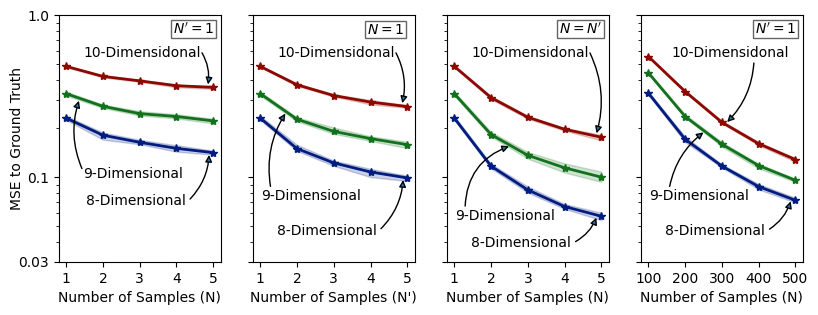

In [150]:
mplglbls = ruyaml.safe_load("""
  ycol: Performance/Deterministic/Train Volumes 3/Main/Normalized/MSE
  figsize: [2.2, 3.8]
  smry/sel: Performance/Deterministic/Train Volumes 3/Main/Normalized/MSE/mean
  smry/cri: min
  colorspec: 
    blue: '#001c7f'
    orange: '#b1400d'
    green: '#12711c'
    red: '#8c0800'
    purple: '#591e71'
    brown: '#592f0d'
    pink: '#a23582'
    gray: '#3c3c3c'
    yellow: '#b8850a'
    cyan: '#006374'
    black: '#000000'
  yscale: log
  ax.plot/marker: '*'
  ax.plot/lw: 2
  arrowprops/arrowstyle: "-|>"
  ax.annotate/xycoords: axes fraction 
  ax.annotate/textcoords: axes fraction
  ylim: [0.03, 1.0]
  yticks: [0.03, 0.1, 1.]
  yticklabels: ['0.03', '0.1', '1.0']
  ylabelpad: -4
""")


mpldict1 = yaml.safe_load("""
kind: line
ylabel: MSE to Ground Truth
xlabel: Number of Samples (N)
xticks: [1, 2, 3, 4, 5]
xcol: srfpts/n/trg
elements:
  10D:
    include: [{srfpts/n/mdl: 1, trg/btstrp: true, dim: 10}]
    ax.plot/color: red
    ax.annotate/text: "10-Dimensidonal"
    ax.annotate/xytext: [0.15, 0.83]
    ax.annotate/xy: [0.92, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  9D:
    include: [{srfpts/n/mdl: 1, trg/btstrp: true, dim: 9}]
    ax.plot/color: green
    ax.annotate/text: "9-Dimensional"
    ax.annotate/xytext: [0.15, 0.34]
    ax.annotate/xy: [0.13, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  8D:
    include: [{srfpts/n/mdl: 1, trg/btstrp: true, dim: 8}]
    ax.plot/color: blue
    ax.annotate/text: "8-Dimensional"
    ax.annotate/xytext: [0.17, 0.23]
    ax.annotate/xy: [0.93, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.02, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

mpldict2 = yaml.safe_load("""
kind: line
xlabel: Number of Samples (N')
xticks: [1, 2, 3, 4, 5]
xcol: srfpts/n/mdl
elements:
  10D:
    include: [{srfpts/n/trg: 1, trg/btstrp: true, dim: 10}]
    ax.plot/color: red
    ax.annotate/text: "10-Dimensidonal"
    ax.annotate/xytext: [0.15, 0.83]
    ax.annotate/xy: [0.92, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  9D:
    include: [{srfpts/n/trg: 1, trg/btstrp: true, dim: 9}]
    ax.plot/color: green
    ax.annotate/text: "9-Dimensional"
    ax.annotate/xytext: [0.05, 0.25]
    ax.annotate/xy: [0.21, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.1, 1.0]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  8D:
    include: [{srfpts/n/trg: 1, trg/btstrp: true, dim: 8}]
    ax.plot/color: blue
    ax.annotate/text: "8-Dimensional"
    ax.annotate/xytext: [0.15, 0.11]
    ax.annotate/xy: [0.93, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.02, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

mpldict3 = yaml.safe_load("""
kind: line
xlabel: Number of Samples (N)
xticks: [1, 2, 3, 4, 5]
xcol: srfpts/n/mdl
elements:
  10D:
    include: [{srfpts/n/trg: 1, srfpts/n/mdl: 1, trg/btstrp: true, dim: 10},
              {srfpts/n/trg: 2, srfpts/n/mdl: 2, trg/btstrp: true, dim: 10},
              {srfpts/n/trg: 3, srfpts/n/mdl: 3, trg/btstrp: true, dim: 10},
              {srfpts/n/trg: 4, srfpts/n/mdl: 4, trg/btstrp: true, dim: 10},
              {srfpts/n/trg: 5, srfpts/n/mdl: 5, trg/btstrp: true, dim: 10}]
    ax.plot/color: red
    ax.annotate/text: "10-Dimensidonal"
    ax.annotate/xytext: [0.15, 0.83]
    ax.annotate/xy: [0.92, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  9D:
    include: [{srfpts/n/trg: 1, srfpts/n/mdl: 1, trg/btstrp: true, dim: 9},
              {srfpts/n/trg: 2, srfpts/n/mdl: 2, trg/btstrp: true, dim: 9},
              {srfpts/n/trg: 3, srfpts/n/mdl: 3, trg/btstrp: true, dim: 9},
              {srfpts/n/trg: 4, srfpts/n/mdl: 4, trg/btstrp: true, dim: 9},
              {srfpts/n/trg: 5, srfpts/n/mdl: 5, trg/btstrp: true, dim: 9}]
    ax.plot/color: green
    ax.annotate/text: "9-Dimensional"
    ax.annotate/xytext: [0.05, 0.17]
    ax.annotate/xy: [0.4, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.1, 1.0]
    arrowprops/connectionstyle: "arc3,rad=-0.35"
  8D:
    include: [{srfpts/n/trg: 1, srfpts/n/mdl: 1, trg/btstrp: true, dim: 8},
              {srfpts/n/trg: 2, srfpts/n/mdl: 2, trg/btstrp: true, dim: 8},
              {srfpts/n/trg: 3, srfpts/n/mdl: 3, trg/btstrp: true, dim: 8},
              {srfpts/n/trg: 4, srfpts/n/mdl: 4, trg/btstrp: true, dim: 8},
              {srfpts/n/trg: 5, srfpts/n/mdl: 5, trg/btstrp: true, dim: 8}]
    ax.plot/color: blue
    ax.annotate/text: "8-Dimensional"
    ax.annotate/xytext: [0.15, 0.06]
    ax.annotate/xy: [0.93, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.02, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

mpldict4 = yaml.safe_load("""
kind: line
xlabel: Number of Samples (N)
xticks: [100, 200, 300, 400, 500]
xcol: srfpts/n/trg
elements:
  10D:
    include: [{trg/btstrp: false, dim: 10}]
    ax.plot/color: red
    ax.annotate/text: "10-Dimensidonal"
    ax.annotate/xytext: [0.19, 0.83]
    ax.annotate/xy: [0.52, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.7, 0.0]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  9D:
    include: [{trg/btstrp: false, dim: 9}]
    ax.plot/color: green
    ax.annotate/text: "9-Dimensional"
    ax.annotate/xytext: [0.05, 0.25]
    ax.annotate/xy: [0.4, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.2, 1.0]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  8D:
    include: [{trg/btstrp: false, dim: 8}]
    ax.plot/color: blue
    ax.annotate/text: "8-Dimensional"
    ax.annotate/xytext: [0.15, 0.11]
    ax.annotate/xy: [0.93, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.02, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

fig, axes = plt.subplots(1, 4, figsize=(2.4*4, 3.2), dpi=100, sharex=False, sharey=True)

method, ablname, aggdf, hpcols, stcols, _ = dashdata['data'][0]
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[0], **mplglbls, **mpldict1}, aggdf)
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[1], **mplglbls, **mpldict2}, aggdf)
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[2], **mplglbls, **mpldict3}, aggdf)
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[3], **mplglbls, **mpldict4}, aggdf)

bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
axes[0].text(3.9, 0.77, '$N\'=1$', bbox=bbox)
axes[1].text(3.9, 0.77, '$N=1$', bbox=bbox)
axes[2].text(3.85, 0.77, '$N=N\'$', bbox=bbox)
axes[3].text(390, 0.77, '$N\'=1$', bbox=bbox);

In [151]:
fig.savefig(f'{workdir}/49_mse_vs_nsamp_hdp.pdf', bbox_inches="tight")

## The Integration Method Study for the Quadrature and QMC Methods

The generated figure is named `51_mse_vs_nsamp_qpois.pdf` and is the same as Figure 18 in the paper's supplement.

Relevant model training configs are `01_poisson/28_hindim.json`. 

These study the sampling space dimension effect on the quadrature and qmc methods. 

In other words, this experiment examine the difference between cube-to-sphere and normal-scaling sampling methods for integration using the quadrature and QMC methods.

In [607]:
smrypath = f'../summary/16_qpois2d.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
hpdf = data['hp']
statdf = data['stat']

ymlpath = f'{workdir}/50_poisshidim.yml'
data = [('Main', hpdf, statdf)]
dashdata = get_dashdata(data, ymlpath, write_yml=False)

Disk usage for "../summary/16_qpois2d.h5"
hp                                                                               74.864 MB
stat                                                                           1092.425 MB
------------------------------------------------------------------------------------------
Total                                                                             1.167 GB


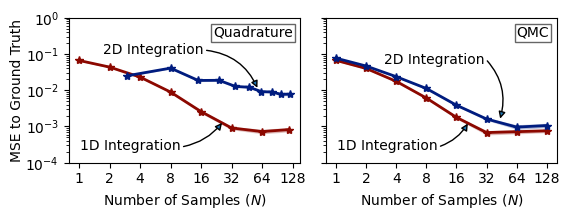

In [617]:
mplglbls = ruyaml.safe_load("""
  ycol: Performance/Deterministic/Train Volumes 3/Main/Normalized/MSE
  figsize: [2.2, 3.8]
  smry/sel: Performance/Deterministic/Train Volumes 3/Main/Normalized/MSE/mean
  smry/cri: min
  colorspec: 
    blue: '#001c7f'
    orange: '#b1400d'
    green: '#12711c'
    red: '#8c0800'
    purple: '#591e71'
    brown: '#592f0d'
    pink: '#a23582'
    gray: '#3c3c3c'
    yellow: '#b8850a'
    cyan: '#006374'
    black: '#000000'
  yscale: log
  ax.plot/marker: '*'
  ax.plot/lw: 2
  arrowprops/arrowstyle: "-|>"
  ax.annotate/xycoords: axes fraction 
  ax.annotate/textcoords: axes fraction
  ylim: [0.0001, 1.0]
  yticks: [0.0001, 0.001, 0.01, 0.1, 1.]
  yticklabels: ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$']
  ylabelpad: -4
  xscale: log
  xticks: [1, 2, 4, 8, 16, 32, 64, 128]
  xticklabels: [1, 2, 4, 8, 16, 32, 64, 128]
""")


mpldict1 = yaml.safe_load("""
kind: line
ylabel: MSE to Ground Truth
xlabel: Number of Samples ($N$)
ylabelpad: 1
xcol: srfpts/n/trg
elements:
  quadc2s:
    include: [{srfpts/samp/dstr: quad, srfpts/samp/rule: gaussian, srfpts/trnsfrm/dstr: cube2sphr, trg/btstrp: false}]
    ax.plot/color: red
    ax.annotate/text: "1D Integration"
    ax.annotate/xytext: [0.05, 0.09]
    ax.annotate/xy: [0.67, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  quadns:
    include: [{srfpts/samp/dstr: quad, srfpts/samp/rule: gaussian, srfpts/trnsfrm/dstr: normscale, trg/btstrp: false}]
    ax.plot/color: blue
    ax.annotate/text: "2D Integration"
    ax.annotate/xytext: [0.15, 0.75]
    ax.annotate/xy: [0.82, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.3"
""")

mpldict2 = yaml.safe_load("""
kind: line
xlabel: Number of Samples ($N$)
xcol: srfpts/n/trg
elements:
  quadc2s:
    include: [{srfpts/samp/dstr: qmc, srfpts/samp/rule: additive_recursion, srfpts/trnsfrm/dstr: cube2sphr, trg/btstrp: false}]
    ax.plot/color: red
    ax.annotate/text: "1D Integration"
    ax.annotate/xytext: [0.05, 0.09]
    ax.annotate/xy: [0.62, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  quadns:
    include: [{srfpts/samp/dstr: qmc, srfpts/samp/rule: additive_recursion, srfpts/trnsfrm/dstr: normscale, trg/btstrp: false}]
    ax.plot/color: blue
    ax.annotate/text: "2D Integration"
    ax.annotate/xytext: [0.25, 0.68]
    ax.annotate/xy: [0.75, null]
    bbox/pad: 1
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=-0.3"
""")

fig, axes = plt.subplots(1, 2, figsize=(2.9*2, 2.3), dpi=100, sharex=False, sharey=True)

method, ablname, aggdf, hpcols, stcols, _ = dashdata['data'][0]
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[0], **mplglbls, **mpldict1}, aggdf)
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[1], **mplglbls, **mpldict2}, aggdf)

from matplotlib import ticker
axes[0].xaxis.set_minor_locator(ticker.NullLocator())
axes[1].xaxis.set_minor_locator(ticker.NullLocator())

bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
axes[0].text(21, 0.3, 'Quadrature', bbox=bbox)
axes[1].text(64, 0.3, 'QMC', bbox=bbox)

fig.set_tight_layout(True)

In [618]:
fig.savefig(f'{workdir}/51_mse_vs_nsamp_qpois.pdf', bbox_inches="tight")

# The Maxwell Problem

### The Training Curves Dashboard

The generated file is named `33_btsmaxwell.html`.

Relevant configs are `01_poisson/02_rect.json`. 

This draws a dashboard for a grid search on the `trg/tau` and `trg/reg/w` HPs, since they controlled the convergence and peak performance.

In [ ]:
smrypath = f'../summary/10_maxwell.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
hpdf = data['hp']
statdf = data['stat']

ymlpath = f'{workdir}/32_btsmaxwell.yml'
data=[('Fixed trg/tau',   hpdf, statdf),
      ('Fixed trg/reg/w', hpdf, statdf)]
dashdata = get_dashdata(data, ymlpath, write_yml=False)

fulllayout = build_dashboard(None, **dashdata)
output_file(f'{workdir}/33_btsmaxwell.html')
save(fulllayout, title=dashdata['header'])

Disk usage for "../summary/10_maxwell.h5"
hp                                                                               12.130 MB
stat                                                                            139.625 MB
------------------------------------------------------------------------------------------
Total                                                                             0.152 GB


'/shared-mounts/sinhas/Saba/code_bspinn/notebook/25_plotting/33_btsmaxwell.html'

### The Grid Search Training Curves Figure

The generated figure is named `53_mse_vs_epoch_maxwell.pdf` and is the same as Figure 19 in the supplement.

Relevant model training configs are `02_maxwell/02_rect.json`. 

These are the `lambda` vs `tau` grid search results in the maxwell problem.

In [181]:
smrypath = f'../summary/10_maxwell.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
hpdf = data['hp']
statdf = data['stat']

ymlpath = f'{workdir}/52_btsmaxwell.yml'
data = [('Main', hpdf, statdf)]
dashdata = get_dashdata(data, ymlpath, write_yml=False)

Disk usage for "../summary/10_maxwell.h5"
hp                                                                               12.635 MB
stat                                                                            145.443 MB
------------------------------------------------------------------------------------------
Total                                                                             0.158 GB


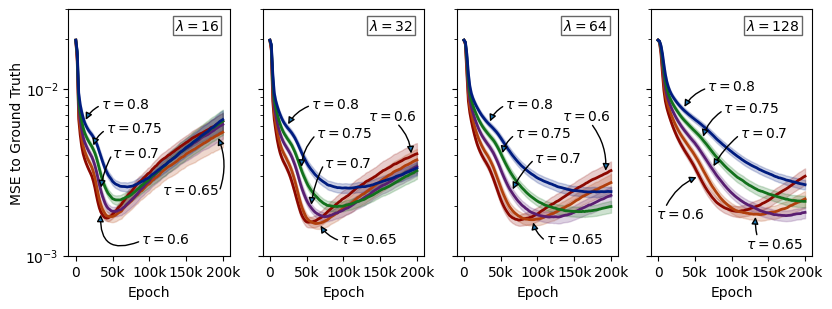

In [194]:
mplglbls = ruyaml.safe_load("""
  ycol: Performance/Train Volumes/Main/Unbiased/MSE
  figsize: [2.2, 3.8]
  colorspec: 
    blue: '#001c7f'
    orange: '#b1400d'
    green: '#12711c'
    red: '#8c0800'
    purple: '#591e71'
    brown: '#592f0d'
    pink: '#a23582'
    gray: '#3c3c3c'
    yellow: '#b8850a'
    cyan: '#006374'
    black: '#000000'
  yscale: log
  ax.plot/lw: 2
  arrowprops/arrowstyle: "-|>"
  ax.annotate/xycoords: axes fraction 
  ax.annotate/textcoords: axes fraction
  ylim: [0.001, 0.03]
  yticks: [0.001, 0.01]
  yticklabels: ['$10^{-3}$', '$10^{-2}$']
  ylabelpad: -4
  xticks: [0, 50000, 100000, 150000, 200000]
  xticklabels: ['0', '50k', '100k', '150k', '200k']
""")


mpldict1 = yaml.safe_load(r"""
kind: line
ylabel: MSE to Ground Truth
xlabel: Epoch
ylabelpad: 1
xcol: Epoch
elements:
  tau=0.8:
    include: [{trg/reg/w: 16, trg/tau: 0.8}]
    ax.plot/color: blue
    ax.annotate/text: "$\\tau=0.8$"
    ax.annotate/xytext: [0.2, 0.60]
    ax.annotate/xy: [0.1, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  tau=0.75:
    include: [{trg/reg/w: 16, trg/tau: 0.75}]
    ax.plot/color: green
    ax.annotate/text: "$\\tau=0.75$"
    ax.annotate/xytext: [0.23, 0.50]
    ax.annotate/xy: [0.15, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  tau=0.7:
    include: [{trg/reg/w: 16, trg/tau: 0.7}]
    ax.plot/color: purple
    ax.annotate/text: "$\\tau=0.7$"
    ax.annotate/xytext: [0.27, 0.40]
    ax.annotate/xy: [0.2, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.1"
  tau=0.65:
    include: [{trg/reg/w: 16, trg/tau: 0.65}]
    ax.plot/color: orange
    ax.annotate/text: "$\\tau=0.65$"
    ax.annotate/xytext: [0.58, 0.25]
    ax.annotate/xy: [0.92, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  tau=0.6:
    include: [{trg/reg/w: 16, trg/tau: 0.6}]
    ax.plot/color: red
    ax.annotate/text: "$\\tau=0.6$"
    ax.annotate/xytext: [0.45, 0.05]
    ax.annotate/xy: [0.20, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=-0.8"
""")

mpldict2 = yaml.safe_load(r"""
kind: line
xlabel: Epoch
ylabelpad: 1
xcol: Epoch
elements:
  tau=0.8:
    include: [{trg/reg/w: 32, trg/tau: 0.8}]
    ax.plot/color: blue
    ax.annotate/text: "$\\tau=0.8$"
    ax.annotate/xytext: [0.3, 0.60]
    ax.annotate/xy: [0.15, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  tau=0.75:
    include: [{trg/reg/w: 32, trg/tau: 0.75}]
    ax.plot/color: green
    ax.annotate/text: "$\\tau=0.75$"
    ax.annotate/xytext: [0.33, 0.48]
    ax.annotate/xy: [0.24, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  tau=0.7:
    include: [{trg/reg/w: 32, trg/tau: 0.7}]
    ax.plot/color: purple
    ax.annotate/text: "$\\tau=0.7$"
    ax.annotate/xytext: [0.38, 0.36]
    ax.annotate/xy: [0.30, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.1"
  tau=0.65:
    include: [{trg/reg/w: 32, trg/tau: 0.65}]
    ax.plot/color: orange
    ax.annotate/text: "$\\tau=0.65$"
    ax.annotate/xytext: [0.48, 0.05]
    ax.annotate/xy: [0.35, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  tau=0.6:
    include: [{trg/reg/w: 32, trg/tau: 0.6}]
    ax.plot/color: red
    ax.annotate/text: "$\\tau=0.6$"
    ax.annotate/xytext: [0.65, 0.55]
    ax.annotate/xy: [0.92, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.6, 0.0]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

mpldict3 = yaml.safe_load(r"""
kind: line
xlabel: Epoch
ylabelpad: 1
xcol: Epoch
elements:
  tau=0.8:
    include: [{trg/reg/w: 64, trg/tau: 0.8}]
    ax.plot/color: blue
    ax.annotate/text: "$\\tau=0.8$"
    ax.annotate/xytext: [0.3, 0.60]
    ax.annotate/xy: [0.2, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  tau=0.75:
    include: [{trg/reg/w: 64, trg/tau: 0.75}]
    ax.plot/color: green
    ax.annotate/text: "$\\tau=0.75$"
    ax.annotate/xytext: [0.36, 0.48]
    ax.annotate/xy: [0.28, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  tau=0.7:
    include: [{trg/reg/w: 64, trg/tau: 0.7}]
    ax.plot/color: purple
    ax.annotate/text: "$\\tau=0.7$"
    ax.annotate/xytext: [0.48, 0.38]
    ax.annotate/xy: [0.34, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.1"
  tau=0.65:
    include: [{trg/reg/w: 64, trg/tau: 0.65}]
    ax.plot/color: orange
    ax.annotate/text: "$\\tau=0.65$"
    ax.annotate/xytext: [0.55, 0.05]
    ax.annotate/xy: [0.47, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  tau=0.6:
    include: [{trg/reg/w: 64, trg/tau: 0.6}]
    ax.plot/color: red
    ax.annotate/text: "$\\tau=0.6$"
    ax.annotate/xytext: [0.65, 0.55]
    ax.annotate/xy: [0.92, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.6, 0.0]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

mpldict4 = yaml.safe_load(r"""
kind: line
xlabel: Epoch
ylabelpad: 1
xcol: Epoch
elements:
  tau=0.8:
    include: [{trg/reg/w: 128, trg/tau: 0.8}]
    ax.plot/color: blue
    ax.annotate/text: "$\\tau=0.8$"
    ax.annotate/xytext: [0.35, 0.67]
    ax.annotate/xy: [0.2, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  tau=0.75:
    include: [{trg/reg/w: 128, trg/tau: 0.75}]
    ax.plot/color: green
    ax.annotate/text: "$\\tau=0.75$"
    ax.annotate/xytext: [0.45, 0.58]
    ax.annotate/xy: [0.32, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  tau=0.7:
    include: [{trg/reg/w: 128, trg/tau: 0.7}]
    ax.plot/color: purple
    ax.annotate/text: "$\\tau=0.7$"
    ax.annotate/xytext: [0.55, 0.48]
    ax.annotate/xy: [0.38, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=0.1"
  tau=0.65:
    include: [{trg/reg/w: 128, trg/tau: 0.65}]
    ax.plot/color: orange
    ax.annotate/text: "$\\tau=0.65$"
    ax.annotate/xytext: [0.59, 0.03]
    ax.annotate/xy: [0.65, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.2, 1.0]
    arrowprops/connectionstyle: "arc3,rad=-0.1"
  tau=0.6:
    include: [{trg/reg/w: 128, trg/tau: 0.6}]
    ax.plot/color: red
    ax.annotate/text: "$\\tau=0.6$"
    ax.annotate/xytext: [0.03, 0.15]
    ax.annotate/xy: [0.3, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.2, 1.0]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

fig, axes = plt.subplots(1, 4, figsize=(2.4*4, 3.2), dpi=100, sharex=False, sharey=True)

method, ablname, aggdf, hpcols, stcols, _ = dashdata['data'][0]
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[0], **mplglbls, **mpldict1}, aggdf)
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[1], **mplglbls, **mpldict2}, aggdf)
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[2], **mplglbls, **mpldict3}, aggdf)
fig, ax = draw_matplotlib({'fig': fig, 'ax': axes[3], **mplglbls, **mpldict4}, aggdf)

bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
axes[0].text(13.5e4, 0.0225, r'$\lambda=16$', bbox=bbox)
axes[1].text(13.5e4, 0.0225, r'$\lambda=32$', bbox=bbox)
axes[2].text(13.5e4, 0.0225, r'$\lambda=64$', bbox=bbox)
axes[3].text(12.0e4, 0.0225, r'$\lambda=128$', bbox=bbox);

In [195]:
fig.savefig(f'{workdir}/53_mse_vs_epoch_maxwell.pdf', bbox_inches="tight")

### The Maxwell Problem Training Curve Figure

The generated dashbaord is named `39_mse_vs_epoch_maxwell.pdf` and corresponds to Figure 5 in the main paper.

Relevant model training configs are `03_maxwell/04_mse.json`, `03_maxwell/05_btstrp.json`, and `03_maxwell/06_ds.json`. 

In [387]:
smrypath = f'../summary/06_maxwell.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data1 = load_h5data(smrypath)
hpdf1 = data1['hp']
statdf1 = data1['stat']

smrypath = f'../summary/10_maxwell.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data2 = load_h5data(smrypath)
hpdf2 = data2['hp']
statdf2 = data2['stat']

i1 = (hpdf1['trg/btstrp'] == False)
i2 = (hpdf2['trg/tau'] == 0.75) & (hpdf2['trg/reg/w'] == 64)

hpdf = pd.concat([hpdf1[i1], hpdf2[i2]], axis=0, ignore_index=True)
statdf = pd.concat([statdf1[i1], statdf2[i2]], axis=0, ignore_index=True)

# we need to make some adjustments to hpdf to avoid pandas bugs.
hpdf['fpidx'] = pd.Categorical(hpdf['fpidx'])
hpdf['fpidxgrp'] = pd.Categorical(hpdf['fpidxgrp'])
for col in hpdf.columns:
    if hpdf.dtypes[col] == 'category':
        if nullstr not in hpdf[col].cat.categories:
            hpdf[col] = hpdf[col].cat.add_categories(nullstr)

Disk usage for "../summary/06_maxwell.h5"
hp                                                                                7.283 MB
stat                                                                             77.571 MB
------------------------------------------------------------------------------------------
Total                                                                             0.085 GB
Disk usage for "../summary/10_maxwell.h5"
hp                                                                               12.130 MB
stat                                                                            139.625 MB
------------------------------------------------------------------------------------------
Total                                                                             0.152 GB


In [388]:
ymlpath = f'{workdir}/38_maxwell.yml'
data = [('Main', hpdf, statdf)]
dashdata = get_dashdata(data, ymlpath, write_yml=False)

def get_method_maxwell2(df):
    i_bts = (df['trg/btstrp'] == True)
    i_ds = (df['srfpts/dblsmpl'] == True)
    i_dts = (df['srfpts/detspc'] == True)
    i_std = ~( i_dts | i_bts | i_ds)
    n_sim = df['srfpts/n/trg'] + df['srfpts/n/mdl'] - 1
    n_sim[n_sim == 99] = 100

    df.loc[i_bts, 'method'] = 'Delayed Target'
    df.loc[i_ds,  'method'] = 'Dbl Sampling'
    df.loc[i_dts,  'method'] = 'Det Sampling'
    df.loc[i_std, 'method'] = 'Standard'
    df.loc[:, 'method'] += ' (N=' + n_sim.loc[:].astype('str') + ')'
    method_col = df['method']
    df.drop(columns='method', inplace=True)
    return method_col

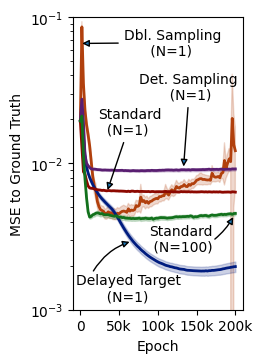

In [440]:
pltdf = dashdata['data'][0][2].copy(deep=True)
pltdf.loc[:, 'method'] = get_method_maxwell2(pltdf)

xcol = 'epoch'
ycol = 'perf/tv/mdl/bc/mse'
huecol = 'method'
fig, ax = plt.subplots(1, 1, figsize=(2.2, 3.8), dpi=100)

snspald = {'blue': '#001c7f', 'orange': '#b1400d', 'green': '#12711c', 
    'red': '#8c0800', 'purple': '#591e71', 'brown': '#592f0d', 'pink': '#a23582',
    'gray': '#3c3c3c', 'yellow': '#b8850a', 'cyan': '#006374', 'black': '#000000'}
meth2clr = {'Delayed Target (N=1)': 'blue', 'Standard (N=1)': 'red', 'Standard (N=100)': 'green', 
            'Dbl Sampling (N=1)': 'orange', 'Det Sampling (N=1)': 'purple'}

for hue, huedf in pltdf.groupby(huecol):
    color = meth2clr[hue]
    color = snspald.get(color, color)
    ax.plot(huedf[xcol], huedf[f'{ycol}/mean'], lw=2, color=color)
    ax.fill_between(huedf[xcol], huedf[f'{ycol}/low'], huedf[f'{ycol}/high'], color=color, alpha=0.2)

ax.set_yscale('log')
ax.set_ylim(0.001, 0.1)
ax.set_xticks([0, 50_000, 100_000, 150_000, 200_000])
ax.set_xticklabels(['0', '50k', '100k', '150k', '200k'])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE to Ground Truth')

ax.annotate(xy=(0.04, 0.91), xytext=(0.3, 0.87), text='Dbl. Sampling\n      (N=1)', 
    arrowprops=dict(arrowstyle="-|>", relpos=(0.0, 0.5), connectionstyle="arc3,rad=0.0"), 
    xycoords='axes fraction')

ax.annotate(xy=(0.65, 0.48), xytext=(0.39, 0.72), text='Det. Sampling\n       (N=1)', 
    arrowprops=dict(arrowstyle="-|>", relpos=(0.5, 0.0), connectionstyle="arc3,rad=0.0"), 
    xycoords='axes fraction')

ax.annotate(xy=(0.2, 0.4), xytext=(0.15, 0.6), text='Standard\n  (N=1)', 
    arrowprops=dict(arrowstyle="-|>", relpos=(0.43, 0.0), connectionstyle="arc3,rad=0.0"), 
    xycoords='axes fraction')

ax.annotate(xy=(0.95, 0.325), xytext=(0.45, 0.20), text='Standard\n (N=100)', 
    arrowprops=dict(arrowstyle="-|>", relpos=(1.03, 0.5), shrinkA=0, connectionstyle="arc3,rad=0.1"), 
    bbox=dict(pad=100, facecolor='none', edgecolor='none'),
    xycoords='axes fraction')

ax.annotate(xy=(0.35, 0.235), xytext=(0.02, 0.03), text='Delayed Target\n       (N=1)', 
    arrowprops=dict(arrowstyle="-|>", relpos=(0.15, 1.0), shrinkA=0, connectionstyle="arc3,rad=-0.2"), 
    xycoords='axes fraction');

In [441]:
fig.savefig(f'{workdir}/39_mse_vs_epoch_maxwell.pdf', bbox_inches="tight")

In [ ]:
fulllayout = build_dashboard(None, **dashdata)
output_file(f'{workdir}/08_maxwell.html')
save(fulllayout, title=dashdata['header'])

### The Maxwell Problem Heatmaps

The generated dashbaord is named `09_hmap_maxwell.pdf` and corresponds to Figure 5 in the main paper.

Relevant model training configs are `03_maxwell/01_rect.json` and `03_maxwell/03_rect.json`. 

In [ ]:
rio = resio(['03_maxwell/01_rect', '03_maxwell/03_rect'], full=False, driver=None)
hpdf1, info1 = rio('hp', ret_info=True)

In [ ]:
mdl_sol1, info2 = rio('var/eval/ug2/sol/mdl', ret_info=True)

In [ ]:
gt_sol1, info3 = rio('var/eval/ug2/sol/gt', ret_info=True)

In [ ]:
n_g1, n_g2, n_g3, dim = 200, 200, 7, 3
plt_epoch = 200000
join_axes = True

nrows, ncols = 2, 3
if join_axes:
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, 
        dpi=100, figsize=(1.9*ncols, 2.0*nrows), constrained_layout=True)
    axes = np.array(axes).reshape(nrows, ncols)
    figs = np.array([[fig] * ncols] * nrows)
else:
    figaxes = [plt.subplots(1, 1, dpi=100, figsize=(2.6, 2.6)) 
        for _ in range(nrows*ncols)]
    figs, axes = tuple(zip(*figaxes))
    axes = np.array(axes).reshape(nrows, ncols)
    figs = np.array(figs).reshape(nrows, ncols)

cnorm = mpl.colors.Normalize(vmin=-0.33, vmax=0.33)

ax = axes[0, 0]
x1_1d = np.linspace(-1, 1, n_g1)
x2_1d = np.linspace(-1, 1, n_g2)
x1, x2 = np.meshgrid(x1_1d, x2_1d)
gt_sol2 = gt_sol1[0]
assert gt_sol2.shape == (n_g1*n_g2*n_g3, dim)
gt_sol3 = gt_sol2 - gt_sol2.mean(axis=0, keepdims=True)
assert gt_sol3.shape == (n_g1*n_g2*n_g3, dim)
gt_sol4 = gt_sol3.reshape(n_g1, n_g2, n_g3, dim)[:, :, 3, 2]
assert gt_sol4.shape == (n_g1, n_g2)
ax.pcolormesh(x2, x1, gt_sol4, cmap='RdBu', shading='auto', 
    norm=cnorm, linewidth=0, rasterized=True)
ax.set_title('Ground Truth')


ax = axes[0, 1]
cfgs = []
method, conds = 'Delayed Target (N=1)',   {'trg/btstrp': True, 'srfpts/n/trg': 1, 
                                           'trg/reg/w': 64, 'trg/tau': 0.75}
cfgs.append([method, conds, 0, 1, plt_epoch])
method, conds = 'Standard (N=100)',      {'trg/btstrp': False, 'srfpts/dblsmpl': False, 
                                          'srfpts/detspc': False, 'srfpts/n/trg': 100}
cfgs.append([method, conds, 0, 2, plt_epoch])
method, conds = 'Standard (N=1)',        {'trg/btstrp': False, 'srfpts/dblsmpl': False, 
                                          'srfpts/detspc': False, 'srfpts/n/trg': 1}
cfgs.append([method, conds, 1, 0, plt_epoch])
method, conds = 'Det. Sampling (N=1)',   {'srfpts/detspc': True, 'srfpts/n/trg': 1}
cfgs.append([method, conds, 1, 1, plt_epoch])
method, conds = 'Dbl. Sampling (N=1)', {'srfpts/dblsmpl': True, 'srfpts/n/trg': 2}
cfgs.append([method, conds, 1, 2, plt_epoch])

for method, conds, row, col, plt_epoch2 in cfgs:
    ax = axes[row, col]
    fig = figs[row, col]
    i_bts = get_dfidxs(hpdf1, conds)
    fpidx_bts = info1.loc[i_bts, 'fpidx'].unique()[0]
    isol_bts = get_dfidxs(info2, {'fpidx': fpidx_bts, 'epoch': plt_epoch2})
    nsol_bts = isol_bts.sum()
    epoch_bts = info2.loc[isol_bts, 'epoch']
    rseed_bts = info2.loc[isol_bts, 'rng_seed']
    msol_bts = mdl_sol1[isol_bts]
    assert msol_bts.shape == (nsol_bts, n_g1*n_g2*n_g3, dim)
    msol_bts2 = msol_bts.mean(axis=0)
    assert msol_bts2.shape == (n_g1*n_g2*n_g3, dim)
    msol_bts3 = msol_bts2 - msol_bts2.mean(axis=0, keepdims=True)
    assert msol_bts3.shape == (n_g1*n_g2*n_g3, dim)
    msol_bts4 = msol_bts3.reshape(n_g1, n_g2, n_g3, dim)
    assert msol_bts4.shape == (n_g1, n_g2, n_g3, dim)
    msol_bts5 = msol_bts4[:, :, 3, 2]
    assert msol_bts5.shape == (n_g1, n_g2)
    im = ax.pcolormesh(x2, x1, msol_bts5, cmap='RdBu', norm=cnorm, 
        shading='auto', linewidth=0, rasterized=True)
    ax.set_title(method, fontsize=11)
    if (row < 2) and (col == ncols-1):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax)

ax.set_yticks([-1., 0., 1.]);

In [ ]:
fig.savefig(f'{workdir}/09_hmap_maxwell.pdf', bbox_inches="tight")

# The Supplementary Ablation Figures

## The 2-Dimensional Poisson Problem

### The Training Curves Dashboard

In [4]:
smrypath = f'../summary/20_poisson2d.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
data_ = hie2deep(data, maxdepth=1)
dfd_bts = data_['bts']
dfd_mse = data_['mse']
dfd_ds = data_['ds']
hpdf_mse = dfd_mse['hp']
statdf_mse = dfd_mse['stat']
hpdf_bts = dfd_bts['hp']
statdf_bts = dfd_bts['stat']
hpdf_ds = dfd_ds['hp']
statdf_ds = dfd_ds['stat']

Disk usage for "../summary/20_poisson2d.h5"
ds/hp                                                                            37.833 MB
bts/hp                                                                           41.591 MB
mse/hp                                                                           38.803 MB
bts/stat                                                                        434.387 MB
mse/stat                                                                        219.779 MB
ds/stat                                                                         214.285 MB
------------------------------------------------------------------------------------------
Total                                                                             0.987 GB


In [5]:
ymlpath = f'{workdir}/58_poisson.yml'
data = [('Standard Training',  hpdf_mse, statdf_mse),
        ('Bootstrapping',      hpdf_bts, statdf_bts),
        ('Double Sampling',    hpdf_ds,  statdf_ds )]

dashdata = get_dashdata(data, ymlpath, write_yml=False)

In [6]:
fulllayout = build_dashboard(None, **dashdata)
output_file(f'{workdir}/59_poisson.html')
save(fulllayout, title=dashdata['header'])

'/code_bspinn/notebook/29_plotting/59_poisson.html'

### The Supplementary Figures

In [7]:
smrypath = f'../summary/20_poisson2d.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
data_ = hie2deep(data, maxdepth=1)
dfd_bts = data_['bts']
dfd_mse = data_['mse']
dfd_ds = data_['ds']
hpdf_mse = dfd_mse['hp']
statdf_mse = dfd_mse['stat']
hpdf_bts = dfd_bts['hp']
statdf_bts = dfd_bts['stat']
hpdf_ds = dfd_ds['hp']
statdf_ds = dfd_ds['stat']

Disk usage for "../summary/20_poisson2d.h5"
ds/hp                                                                            37.833 MB
bts/hp                                                                           41.591 MB
mse/hp                                                                           38.803 MB
bts/stat                                                                        434.387 MB
mse/stat                                                                        219.779 MB
ds/stat                                                                         214.285 MB
------------------------------------------------------------------------------------------
Total                                                                             0.987 GB


In [8]:
ymlpath = f'{workdir}/60_poisson.yml'
data = [('Standard Training',  hpdf_mse, statdf_mse),
        ('Bootstrapping',      hpdf_bts, statdf_bts),
        ('Double Sampling',    hpdf_ds,  statdf_ds )]

dashdata_poiss = get_dashdata(data, ymlpath, write_yml=False)

poissdir = f'{suppdir}/01_poisson'
! mkdir -p {poissdir}

In [9]:
mplglbls_pois = ruyaml.safe_load("""
  ycol: Performance/I.I.D./Uniform Rectangle/Main/Flattened/MSE
  ylabel: MSE to Ground Truth
  figsize: [2.5, 2.5]
  smry/sel: Performance/I.I.D./Uniform Rectangle/Main/Flattened/MSE/mean
  smry/cri: min
  colorspec: 
    blue: '#001c7f'
    orange: '#b1400d'
    green: '#12711c'
    red: '#8c0800'
    purple: '#591e71'
    brown: '#592f0d'
    pink: '#a23582'
    gray: '#3c3c3c'
    yellow: '#b8850a'
    cyan: '#006374'
    black: '#000000'
  yscale: log
  ax.bar/capsize: 7
  ax.bar/ecolor: black
  ax.bar/edgecolor: black
  ax.bar/linewidth: 2.0
  ax.bar/log: true
  ax.bar/width: 0.5
  arrowprops/arrowstyle: "-|>"
  ax.annotate/xycoords: axes fraction 
  ax.annotate/textcoords: axes fraction
  ylim: [3e-6, 3e-1]
  yticks: null
  yticklabels: null
  xticks: null
  ylabelpad: null
""")

#### Figure Batch 1: Sampling Scheme

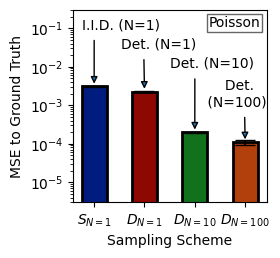

In [10]:
method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][1]

mpldict = yaml.safe_load("""
kind: bar
xcol: Sampling Scheme
xlabel: Sampling Scheme
ylabel: MSE to Ground Truth
elements:
  $S_{N=1}$:
    include: [{srfpts/detspc: false}]
    ax.bar/color: blue
    ax.annotate/text: I.I.D. (N=1)
    ax.annotate/xytext: [0.05, 0.9]
    arrowprops/relpos: [0.15, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $D_{N=1}$:
    include: [{srfpts/detspc: true, srfpts/n/trg: 1,    vol/n: 400}]
    ax.bar/color: red
    ax.annotate/text: Det. (N=1)
    ax.annotate/xytext: [0.25, 0.8]
    arrowprops/relpos: [0.3, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $D_{N=10}$:
    include: [{srfpts/detspc: true, srfpts/n/trg: 10,   vol/n:  80}]
    ax.bar/color: green
    ax.annotate/text: Det. (N=10)
    ax.annotate/xytext: [0.5, 0.7]
    arrowprops/relpos: [0.3, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $D_{N=100}$:
    include: [{srfpts/detspc: true, srfpts/n/trg: 100,  vol/n:   8}]
    ax.bar/color: orange
    ax.annotate/text: "     Det.\\n (N=100)"
    ax.annotate/xytext: [0.67, 0.5]
    arrowprops/relpos: [0.66, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.7, 0.91, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/01_mse_vs_sampling.pdf', bbox_inches="tight")

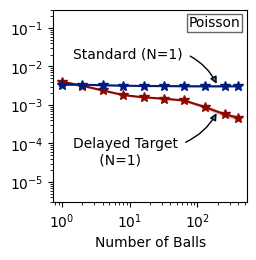

In [11]:
mpldict = yaml.safe_load("""
kind: line
xcol: vol/n
xlabel: Number of Balls
xscale: log
ax.plot/marker: '*'
ax.plot/markersize: 7

# Remove the following two lines for bringing back ylabel and ticks
# yticklabels: []
ylabel: null

elements:
  Standard:
    exclude: [{trg/btstrp: true}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=1)"
    ax.annotate/xytext: [0.1, 0.75]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.6]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  Delayed Target:
    exclude: [{trg/btstrp: false}]
    ax.plot/color: red
    ax.annotate/text: "Delayed Target\\n      (N=1)"
    ax.annotate/xytext: [0.1, 0.2]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

aggdf_std = dashdata_poiss['data'][2][2].copy(deep=True)
aggdf_std['trg/btstrp'] = False

aggdf_bts = dashdata_poiss['data'][12][2].copy(deep=True)
aggdf_bts['trg/btstrp'] = True
aggdf_bts['fpidxgrp'] += aggdf_std['fpidx'].max() + 1
aggdf_bts['fpidx'] += aggdf_std['fpidx'].max() + 1

aggdf = pd.concat([aggdf_std, aggdf_bts], axis=0, ignore_index=True)
fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.7, 0.91, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/02_mse_vs_nballs_method.pdf', bbox_inches="tight")

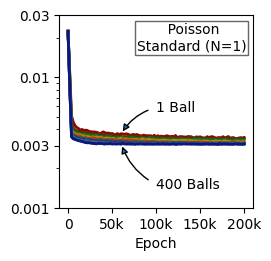

In [12]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
xlabel: Epoch
ylabel: null
smry/sel: null
smry/cri: null
ylim: [0.001, 0.03]
yticks: [0.001, 0.003, 0.01, 0.03]
yticklabels: ["0.001", "0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2
elements:
  1:
    include: [{vol/n: 1}]
    ax.plot/color: red
    ax.annotate/text: "1 Ball"
    ax.annotate/xytext: [0.5, 0.5]
    ax.annotate/xy: [0.32, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  2: {include: [{vol/n: 2}], ax.plot/color: brown}
  4: {include: [{vol/n: 4}], ax.plot/color: green}
  8: {include: [{vol/n: 8}], ax.plot/color: yellow}
  16: {include: [{vol/n: 16}], ax.plot/color: orange}
  32: {include: [{vol/n: 32}], ax.plot/color: cyan}
  64: {include: [{vol/n: 64}], ax.plot/color: purple}
  128: {include: [{vol/n: 128}], ax.plot/color: teal}
  256: {include: [{vol/n: 256}], ax.plot/color: pink}
  400:
    include: [{vol/n: 400}]
    ax.plot/color: blue
    ax.annotate/text: "400 Balls"
    ax.annotate/xytext: [0.5, 0.1]
    ax.annotate/xy: [0.32, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][2]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.4, 0.82, '       Poisson\nStandard (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/03_mse_vs_epoch_nballs_std.pdf', bbox_inches="tight")

#### Figure Batch 2: Ball Center Distribution

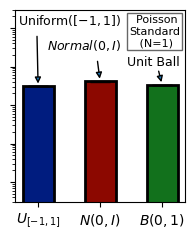

In [13]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Ball Center Distribution
xlabel: Ball Center Distribution
xlabel: null
yticklabels: []
ylabel: MSE to Ground Truth
ylabel: null
figsize: [2.2, 2.5]
elements:
  $U_{[-1, 1]}$:
    include: [{vol/c/dstr: uniform, vol/c/low: "[-1.0]", vol/c/high: "[1.0]"}]
    ax.bar/color: blue
    ax.annotate/text: "Uniform$([-1, 1])$"
    ax.annotate/xytext: [0.02, 0.92]
    ax.annotate/fontsize: 9
    arrowprops/relpos: [0.18, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $N(0,I)$:
    include: [{vol/c/dstr: normal, vol/c/loc: "[0.0]", vol/c/scale: 1.0}]
    ax.bar/color: red
    ax.annotate/text: $Normal(0, I)$
    ax.annotate/xytext: [0.19, 0.79]
    ax.annotate/fontsize: 9
    arrowprops/relpos: [0.65, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $B(0,1)$:
    include: [{vol/c/dstr: ball, vol/c/c: "[0.0]", vol/c/r: 1.0}]
    ax.bar/color: green
    ax.annotate/text: Unit Ball
    ax.annotate/xytext: [0.66, 0.71]
    ax.annotate/fontsize: 9
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.58, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][3]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.67, 0.81, '  Poisson\nStandard\n   (N=1)', transform=ax.transAxes, bbox=bbox, fontsize=8)

fig.savefig(f'{poissdir}/04_mse_vs_ballc_std.pdf', bbox_inches="tight")

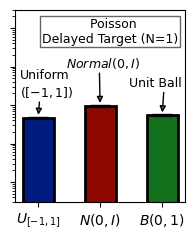

In [14]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Ball Center Distribution
xlabel: Ball Center Distribution
xlabel: null
ylabel: MSE to Ground Truth

figsize: [3.5, 2.5]
# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

figsize: [2.2, 2.5]

elements:
  $U_{[-1, 1]}$:
    include: [{vol/c/dstr: uniform, vol/c/low: "[-1.0]", vol/c/high: "[1.0]"}]
    ax.bar/color: blue
    ax.annotate/text: "Uniform\\n$([-1, 1])$"
    ax.annotate/fontsize: 9
    ax.annotate/xytext: [0.03, 0.55]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.37, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $N(0,I)$:
    include: [{vol/c/dstr: normal, vol/c/loc: "[0.0]", vol/c/scale: 1.0}]
    ax.bar/color: red
    ax.annotate/text: $Normal(0, I)$
    ax.annotate/fontsize: 9
    ax.annotate/xytext: [0.3, 0.7]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.45, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $B(0,1)$:
    include: [{vol/c/dstr: ball, vol/c/c: "[0.0]", vol/c/r: 1.0}]
    ax.bar/color: green
    ax.annotate/text: Unit Ball
    ax.annotate/fontsize: 9
    ax.annotate/xytext: [0.67, 0.6]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.66, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][13]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.16, 0.83, '            Poisson\nDelayed Target (N=1)', transform=ax.transAxes, bbox=bbox, fontsize=9)

fig.savefig(f'{poissdir}/05_mse_vs_ballc_bts.pdf', bbox_inches="tight")

#### Figure Batch 3: Ball Radius Distribution

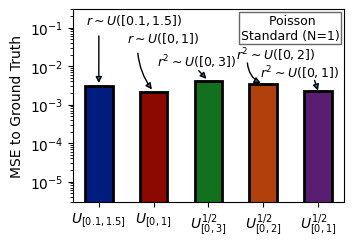

In [15]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Ball Radius Distribution
xlabel: Ball Radius Distribution
xlabel: null
ylabel: MSE to Ground Truth
figsize: [3.5, 2.5]
elements:
  $U_{[0.1, 1.5]}$:
    include: [{vol/r/dstr: uniform, vol/r/low: 0.1, vol/r/high: 1.5}]
    ax.bar/color: blue
    ax.annotate/text: $r\sim U([0.1,1.5])$
    ax.annotate/fontsize: 9
    ax.annotate/xytext: [0.05, 0.92]
    arrowprops/relpos: [0.13, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U_{[0,1]}$:
    include: [{vol/r/dstr: uniform, vol/r/low: 0.0, vol/r/high: 1}]
    ax.bar/color: red
    ax.annotate/text: $r\sim U([0,1])$
    ax.annotate/fontsize: 9
    ax.annotate/xytext: [0.2, 0.83]
    arrowprops/relpos: [0.15, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  $U^{1/2}_{[0,3]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: "sqrt(dim+1)"}]
    ax.bar/color: green
    ax.annotate/text: $r^2\sim U([0,3])$
    ax.annotate/fontsize: 9
    ax.annotate/xytext: [0.31, 0.7]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.53, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U^{1/2}_{[0,2]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: "sqrt(dim)"}]
    ax.bar/color: orange
    ax.annotate/text: $r^2\sim U([0,2])$
    ax.annotate/fontsize: 9
    ax.annotate/xytext: [0.6, 0.74]
    arrowprops/relpos: [0.15, 0.0]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.3"
  $U^{1/2}_{[0,1]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: 1}]
    ax.bar/color: purple
    ax.annotate/text: $r^2\sim U([0,1])$
    ax.annotate/fontsize: 9
    ax.annotate/xytext: [0.69, 0.645]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkB: 0
    arrowprops/relpos: [0.68, 0.2]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][4]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.62, 0.845, '       Poisson\nStandard (N=1)', transform=ax.transAxes, bbox=bbox, fontsize=9)

fig.savefig(f'{poissdir}/06_mse_vs_ballr_std.pdf', bbox_inches="tight")

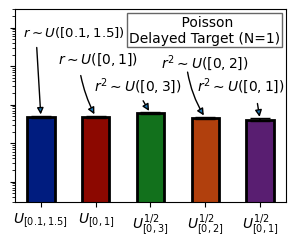

In [16]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Ball Radius Distribution
xlabel: Ball Radius Distribution
xlabel: null
ylabel: MSE to Ground Truth
figsize: [3.5, 2.5]

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  $U_{[0.1, 1.5]}$:
    include: [{vol/r/dstr: uniform, vol/r/low: 0.1, vol/r/high: 1.5}]
    ax.bar/color: blue
    ax.annotate/text: $r\sim U([0.1,1.5])$
    ax.annotate/fontsize: 9.5
    ax.annotate/xytext: [0.03, 0.86]
    arrowprops/relpos: [0.13, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U_{[0,1]}$:
    include: [{vol/r/dstr: uniform, vol/r/low: 0.0, vol/r/high: 1}]
    ax.bar/color: red
    ax.annotate/text: $r\sim U([0,1])$
    ax.annotate/xytext: [0.16, 0.72]
    arrowprops/relpos: [0.25, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.1"
  $U^{1/2}_{[0,3]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: "sqrt(dim+1)"}]
    ax.bar/color: green
    ax.annotate/text: $r^2\sim U([0,3])$
    ax.annotate/xytext: [0.29, 0.58]
    arrowprops/relpos: [0.53, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U^{1/2}_{[0,2]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: "sqrt(dim)"}]
    ax.bar/color: orange
    ax.annotate/text: $r^2\sim U([0,2])$
    ax.annotate/xytext: [0.54, 0.7]
    arrowprops/relpos: [0.3, 0.0]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.1"
  $U^{1/2}_{[0,1]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: 1}]
    ax.bar/color: purple
    ax.annotate/text: $r^2\sim U([0,1])$
    ax.annotate/xytext: [0.67, 0.58]
    arrowprops/relpos: [0.68, 0.0]
    arrowprops/connectionstyle: "arc3,rad=-0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][14]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.42, 0.83, '            Poisson\nDelayed Target (N=1)', transform=ax.transAxes, bbox=bbox, fontsize=10)

fig.savefig(f'{poissdir}/07_mse_vs_ballr_bts.pdf', bbox_inches="tight")

#### Figure Batch 4: Function Approximation

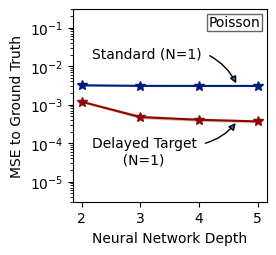

In [17]:
mpldict = yaml.safe_load("""
kind: line
xcol: nn/hidden
xlabel: Neural Network Depth
xscale: linear
ax.plot/marker: '*'
ax.plot/markersize: 7
xticks: [1, 2, 3, 4]
xticklabels: [2, 3, 4, 5]
elements:
  Standard:
    include: [{trg/btstrp: false}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=1)"
    ax.annotate/xytext: [0.1, 0.75]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.6]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  Delayed Target:
    include: [{trg/btstrp: true}]
    ax.plot/color: red
    ax.annotate/text: "Delayed Target\\n       (N=1)"
    ax.annotate/xytext: [0.1, 0.2]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

aggdf_std = dashdata_poiss['data'][6][2].copy(deep=True)
aggdf_std = aggdf_std.sort_values(by=['nn/hidden', 'fpidxgrp'])
aggdf_std['trg/btstrp'] = False

aggdf_bts = dashdata_poiss['data'][16][2].copy(deep=True)
aggdf_bts['trg/btstrp'] = True
aggdf_bts['fpidxgrp'] += aggdf_std['fpidx'].max()+1
aggdf_bts['fpidx'] += aggdf_std['fpidx'].max()+1

aggdf = pd.concat([aggdf_std, aggdf_bts], axis=0, ignore_index=True)
fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.7, 0.91, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/08_mse_vs_depth_method.pdf', bbox_inches="tight")

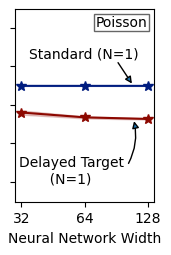

In [18]:
mpldict = yaml.safe_load("""
kind: line
xcol: nn/width
xlabel: Neural Network Width
xscale: log
ax.plot/marker: '*'
ax.plot/markersize: 7
xticks: [32, 64, 128]
xticklabels: ["32", "64", "128"]

figsize: [1.8, 2.5]

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  Standard:
    include: [{trg/btstrp: false}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=1)"
    ax.annotate/xytext: [0.1, 0.75]
    ax.annotate/xy: [0.85, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.8, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  Delayed Target:
    include: [{trg/btstrp: true}]
    ax.plot/color: red
    ax.annotate/text: "Delayed Target\\n       (N=1)"
    ax.annotate/xytext: [0.03, 0.1]
    ax.annotate/xy: [0.85, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.03, 0.65]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

aggdf_std = dashdata_poiss['data'][5][2].copy(deep=True)
aggdf_std['trg/btstrp'] = False

aggdf_bts = dashdata_poiss['data'][18][2].copy(deep=True)
aggdf_bts['trg/btstrp'] = True
aggdf_bts['fpidxgrp'] += aggdf_std['fpidx'].max()+1
aggdf_bts['fpidx'] += aggdf_std['fpidx'].max()+1

aggdf = pd.concat([aggdf_std, aggdf_bts], axis=0, ignore_index=True)
fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.58, 0.91, 'Poisson', transform=ax.transAxes, bbox=bbox)

ax.minorticks_off()

fig.savefig(f'{poissdir}/09_mse_vs_width_method.pdf', bbox_inches="tight")

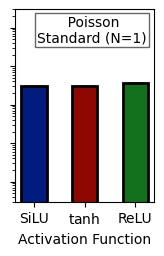

In [19]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Activation Function
xlabel: Activation Function
ylabel: MSE to Ground Truth

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

figsize: [1.8, 2.5]
elements:
  SiLU:
    include: [{nn/act: silu}]
    ax.bar/color: blue
    # ax.annotate/text: SiLU
    # ax.annotate/xytext: [0.05, 0.92]
    # arrowprops/relpos: [0.5, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  $\\tanh$:
    include: [{nn/act: tanh}]
    ax.bar/color: red
    # ax.annotate/text: $\\tanh$
    # ax.annotate/xytext: [0.42, 0.83]
    # arrowprops/relpos: [0.5, 0.5]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  ReLU:
    include: [{nn/act: relu}]
    ax.bar/color: green
    # ax.annotate/text: ReLU
    # ax.annotate/xytext: [0.73, 0.75]
    # arrowprops/relpos: [0.48, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][7]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.16, 0.83, '       Poisson\nStandard (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/10_mse_vs_act_std.pdf', bbox_inches="tight")

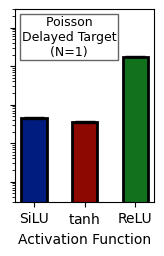

In [20]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Activation Function
xlabel: Activation Function
ylabel: MSE to Ground Truth

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

figsize: [1.8, 2.5]
elements:
  SiLU:
    include: [{nn/act: silu}]
    ax.bar/color: blue
    # ax.annotate/text: SiLU
    # ax.annotate/xytext: [0.05, 0.8]
    # arrowprops/relpos: [0.5, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  $\\tanh$:
    include: [{nn/act: tanh}]
    ax.bar/color: red
    # ax.annotate/text: $\\tanh$
    # ax.annotate/xytext: [0.41, 0.6]
    # arrowprops/relpos: [0.5, 0.5]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  ReLU:
    include: [{nn/act: relu}]
    ax.bar/color: green
    # ax.annotate/text: ReLU
    # ax.annotate/xytext: [0.73, 0.9]
    # arrowprops/relpos: [0.5, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][17]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.05, 0.76, '      Poisson\nDelayed Target\n       (N=1)', transform=ax.transAxes, bbox=bbox, fontsize=9)

fig.savefig(f'{poissdir}/11_mse_vs_act_bts.pdf', bbox_inches="tight")

#### Figure Batch 5: Function Approximation Training Curves

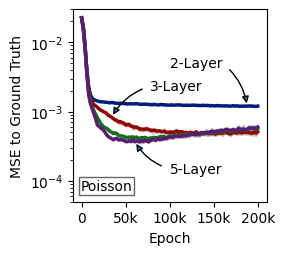

In [21]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
ylim: [0.00005, 0.03]
yticks: [0.0001, 0.001, 0.01]
# yticklabels: ["0.0001", "0.0003", "0.001", "0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2.5
elements:
  1:
    include: [{nn/hidden: 1}]
    ax.plot/color: blue
    ax.annotate/text: "2-Layer"
    ax.annotate/xytext: [0.5, 0.7]
    ax.annotate/xy: [0.9, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  2:
    include: [{nn/hidden: 2}]
    ax.plot/color: red
    ax.annotate/text: "3-Layer"
    ax.annotate/xytext: [0.4, 0.58]
    ax.annotate/xy: [0.2, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  3: {include: [{nn/hidden: 3}], ax.plot/color: green}
  4:
    include: [{nn/hidden: 4}]
    ax.plot/color: purple
    ax.annotate/text: "5-Layer"
    ax.annotate/xytext: [0.5, 0.15]
    ax.annotate/xy: [0.32, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][16]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.04, 0.06, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/12_mse_vs_epoch_depth_bts.pdf', bbox_inches="tight")

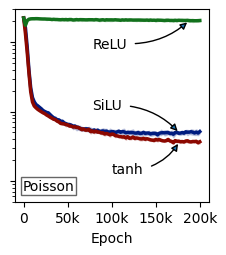

In [22]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
ylim: [0.00005, 0.03]
yticks: [0.0001, 0.001, 0.01]
# yticklabels: ["0.0001", "0.0003", "0.001", "0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2.5

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  1:
    include: [{nn/act: silu}]
    ax.plot/color: blue
    ax.annotate/text: SiLU
    ax.annotate/xytext: [0.4, 0.48]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  2:
    include: [{nn/act: tanh}]
    ax.plot/color: red
    ax.annotate/text: "tanh"
    ax.annotate/xytext: [0.5, 0.15]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  4:
    include: [{nn/act: relu}]
    ax.plot/color: green
    ax.annotate/text: ReLU
    ax.annotate/xytext: [0.4, 0.8]
    ax.annotate/xy: [0.9, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][17]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.04, 0.06, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/13_mse_vs_epoch_act_bts.pdf', bbox_inches="tight")

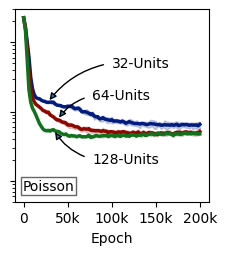

In [23]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
ylim: [0.00005, 0.03]
yticks: [0.0001, 0.001, 0.01]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2.5

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  1:
    include: [{nn/width: 32}]
    ax.plot/color: blue
    ax.annotate/text: "32-Units"
    ax.annotate/xytext: [0.5, 0.7]
    ax.annotate/xy: [0.17, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  2:
    include: [{nn/width: 64}]
    ax.plot/color: red
    ax.annotate/text: "64-Units"
    ax.annotate/xytext: [0.4, 0.53]
    ax.annotate/xy: [0.22, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  4:
    include: [{nn/width: 128}]
    ax.plot/color: green
    ax.annotate/text: "128-Units"
    ax.annotate/xytext: [0.4, 0.2]
    ax.annotate/xy: [0.2, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][18]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.04, 0.06, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/14_mse_vs_epoch_width_bts.pdf', bbox_inches="tight")

#### Figure Batch 6: Poisson Charge Distribution

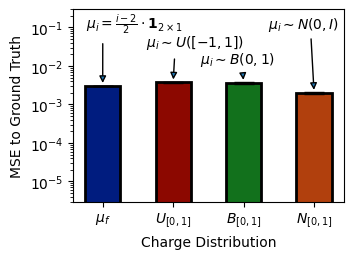

In [24]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Charge Distribution
xlabel: Charge Distribution
ylabel: MSE to Ground Truth
figsize: [3.5, 2.5]
elements:
  $\mu_{f}$:
    include: [{chrg/mu: "[[-0.5], [0.0], [0.5]]"}]
    ax.bar/color: blue
    ax.annotate/text: $\mu_i=\\frac{i-2}{2} \cdot \mathbf{1}_{2\\times 1}$
    ax.annotate/xytext: [0.05, 0.9]
    arrowprops/relpos: [0.17, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U_{[0,1]}$:
    include: [{chrg/mu/dstr: uniform, chrg/mu/low: "[[-1.0]]", chrg/mu/high: "[[1.0]]"}]
    ax.bar/color: red
    ax.annotate/text: $\mu_i\sim U([-1,1])$
    ax.annotate/xytext: [0.27, 0.81]
    arrowprops/relpos: [0.3, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $B_{[0,1]}$:
    include: [{chrg/mu/dstr: ball, chrg/mu/c: "[[0.0]]", chrg/mu/r: "[1.0]"}]
    ax.bar/color: green
    ax.annotate/text: $\mu_i\sim B(0,1)$
    ax.annotate/xytext: [0.47, 0.72]
    arrowprops/relpos: [0.56, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $N_{[0,1]}$:
    include: [{chrg/mu/dstr: normal, chrg/mu/loc: "[[0.0]]", chrg/mu/scale: "[1.0]"}]
    ax.bar/color: orange
    ax.annotate/text: $\mu_i\sim N(0,I)$
    ax.annotate/xytext: [0.72, 0.9]
    arrowprops/relpos: [0.6, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][8]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)

fig.savefig(f'{poissdir}/15_mse_vs_chrgc_std.pdf', bbox_inches="tight")

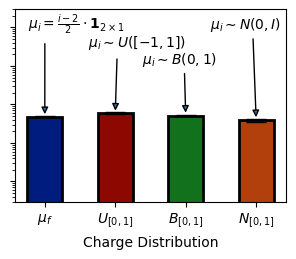

In [25]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Charge Distribution
xlabel: Charge Distribution
ylabel: MSE to Ground Truth
figsize: [3.5, 2.5]

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  $\mu_{f}$:
    include: [{chrg/mu: "[[-0.5], [0.0], [0.5]]"}]
    ax.bar/color: blue
    ax.annotate/text: $\mu_i=\\frac{i-2}{2} \cdot \mathbf{1}_{2\\times 1}$
    ax.annotate/xytext: [0.05, 0.9]
    arrowprops/relpos: [0.17, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U_{[0,1]}$:
    include: [{chrg/mu/dstr: uniform, chrg/mu/low: "[[-1.0]]", chrg/mu/high: "[[1.0]]"}]
    ax.bar/color: red
    ax.annotate/text: $\mu_i\sim U([-1,1])$
    ax.annotate/xytext: [0.27, 0.81]
    arrowprops/relpos: [0.3, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $B_{[0,1]}$:
    include: [{chrg/mu/dstr: ball, chrg/mu/c: "[[0.0]]", chrg/mu/r: "[1.0]"}]
    ax.bar/color: green
    ax.annotate/text: $\mu_i\sim B(0,1)$
    ax.annotate/xytext: [0.47, 0.72]
    arrowprops/relpos: [0.56, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $N_{[0,1]}$:
    include: [{chrg/mu/dstr: normal, chrg/mu/loc: "[[0.0]]", chrg/mu/scale: "[1.0]"}]
    ax.bar/color: orange
    ax.annotate/text: $\mu_i\sim N(0,I)$
    ax.annotate/xytext: [0.72, 0.9]
    arrowprops/relpos: [0.6, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][15]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)

fig.savefig(f'{poissdir}/16_mse_vs_chrgc_bts.pdf', bbox_inches="tight")

#### Figure Batch 7: Delayed Targeting

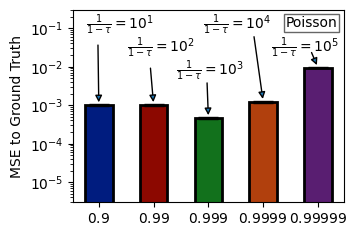

In [26]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Target Smoothing ($\\tau$)
# xlabel: Target Smoothing ($\\tau$)
xlabel: null
ylabel: MSE to Ground Truth
figsize: [3.5, 2.5]
elements:
  $0.9$:
    include: [{trg/tau: 0.9}]
    ax.bar/color: blue
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^1$
    ax.annotate/xytext: [0.05, 0.9]
    arrowprops/relpos: [0.17, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.99$:
    include: [{trg/tau: 0.99}]
    ax.bar/color: red
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^2$
    ax.annotate/xytext: [0.2, 0.78]
    arrowprops/relpos: [0.32, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.999$:
    include: [{trg/tau: 0.999}]
    ax.bar/color: green
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^3$
    ax.annotate/xytext: [0.38, 0.66]
    arrowprops/relpos: [0.46, 0.0]
    arrowprops/shrinkA: 0
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.9999$:
    include: [{trg/tau: 0.9999}]
    ax.bar/color: orange
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^4$
    ax.annotate/xytext: [0.48, 0.9]
    arrowprops/relpos: [0.75, 0.0]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.99999$:
    include: [{trg/tau: 0.99999}]
    ax.bar/color: purple
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^5$
    ax.annotate/xytext: [0.73, 0.78]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.6, 0.3]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][20]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.785, 0.91, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/17_mse_vs_tau.pdf', bbox_inches="tight")

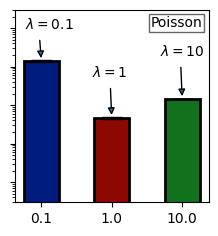

In [27]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Target Regularization
xlabel: Target Regularization
ylabel: MSE to Ground Truth

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null
xlabel: null

elements:
  0.1:
    include: [{trg/reg/w: 0.1}]
    ax.bar/color: blue
    ax.annotate/text: $\\lambda=0.1$
    ax.annotate/xytext: [0.05, 0.9]
    arrowprops/relpos: [0.3, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  1:
    include: [{trg/reg/w: 1.0}]
    ax.bar/color: red
    ax.annotate/text: $\\lambda=1$
    ax.annotate/xytext: [0.4, 0.65]
    arrowprops/relpos: [0.5, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  10:
    include: [{trg/reg/w: 10.0}]
    ax.bar/color: green
    ax.annotate/text: $\\lambda=10$
    ax.annotate/xytext: [0.75, 0.76]
    arrowprops/relpos: [0.45, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][21]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.70, 0.91, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/18_mse_vs_lambda.pdf', bbox_inches="tight")

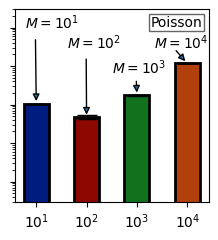

In [28]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Target Weight ($M$)
xlabel: Target Weight ($M$)
ylabel: MSE to Ground Truth
figsize: [2.5, 2.5]

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null
xlabel: null

elements:
  $10^1$:
    include: [{trg/w: 0.9}]
    ax.bar/color: blue
    ax.annotate/text: $M=10^1$
    ax.annotate/xytext: [0.05, 0.9]
    arrowprops/relpos: [0.2, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $10^2$:
    include: [{trg/w: 0.99}]
    ax.bar/color: red
    ax.annotate/text: $M=10^2$
    ax.annotate/xytext: [0.27, 0.8]
    arrowprops/relpos: [0.35, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $10^3$:
    include: [{trg/w: 0.999}]
    ax.bar/color: green
    ax.annotate/text: $M=10^3$
    ax.annotate/xytext: [0.5, 0.67]
    arrowprops/relpos: [0.45, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $10^4$:
    include: [{trg/w: 0.9999}]
    ax.bar/color: orange
    ax.annotate/text: $M=10^4$
    ax.annotate/xytext: [0.72, 0.8]
    arrowprops/relpos: [0.4, 0.0]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][22]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.70, 0.91, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/19_mse_vs_trgw.pdf', bbox_inches="tight")

#### Figure Batch 8: Learning Rate

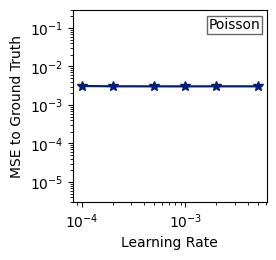

In [29]:
mpldict = yaml.safe_load("""
# ycol: Unbiased MSE to Ground Truth
kind: line
xcol: opt/lr
xlabel: Learning Rate
xscale: log
ax.plot/marker: '*'
ax.plot/markersize: 7
# ylim: [0.001, 0.1]

# Remove the following two lines for bringing back ylabel and ticks
# xticks: [0.0001, 0.0003, 0.001, 0.003]
# xticklabels: ["$10^{-4}$", "$3 \\\\times 10^{-4}$", "$10^{-3}$", "$3 \\\\times 10^{-3}$"]
xticks: [0.0001, 0.001]
xticklabels: ["$10^{-4}$", "$10^{-3}$"]
# ylabel: null

elements:
  Standard:
    # include: [{trg/btstrp: false, pts/detspc: false}]
    ax.plot/color: blue
    # ax.annotate/text: "Standard (N=1)"
    # ax.annotate/xytext: [0.1, 0.8]
    # ax.annotate/xy: [0.85, null]
    # arrowprops/relpos: [1.0, 0.6]
    # arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

aggdf = dashdata_poiss['data'][11][2].copy(deep=True)
fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.70, 0.9, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/20_mse_vs_lr_std.pdf', bbox_inches="tight")

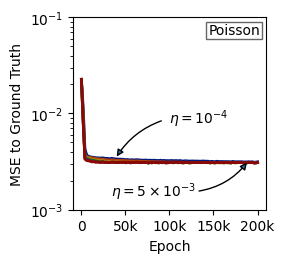

In [30]:
mpldict = yaml.safe_load(r"""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
ylim: [0.001, 0.1]
# yticks: [0.003, 0.01, 0.03]
# yticklabels: ["0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2
# ylabel: null
elements:
  0.005:
    include: [{opt/lr: 0.005}]
    ax.plot/color: red
    ax.annotate/text: "$\\eta=5\\times 10^{-3}$"
    ax.annotate/xytext: [0.2, 0.07]
    ax.annotate/xy: [0.90, null]
    arrowprops/relpos: [1.0, 0.5]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkB: 0
    arrowprops/connectionstyle: "arc3,rad=0.2"
  0.002: {include: [{opt/lr: 0.002}], ax.plot/color: purple}
  0.001: {include: [{opt/lr: 0.001}], ax.plot/color: green}
  0.0005: {include: [{opt/lr: 0.0005}], ax.plot/color: yellow}
  0.0002: {include: [{opt/lr: 0.0002}], ax.plot/color: orange}
  0.0001:
    include: [{opt/lr: 0.0001}]
    ax.plot/color: blue
    ax.annotate/text: "$\\eta=10^{-4}$"
    ax.annotate/xytext: [0.5, 0.45]
    ax.annotate/xy: [0.22, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_poiss['data'][11]

fig, ax = draw_matplotlib({**mplglbls_pois, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.70, 0.91, 'Poisson', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{poissdir}/21_mse_vs_epoch_lr_std.pdf', bbox_inches="tight")

## The Maxwell-Ampere Problem

### The Training Curves Dashboard


The generated dashbaord is named `55_maxwell.html`

Relevant configs are `02_maxwell/04_mse.json`, `02_maxwell/05_btstrp.json`, and `02_maxwell/06_ds.json`. 

These are the various ablation results in the supplementary material for maxwell problem.

In [ ]:
smrypath = f'../summary/17_maxwell.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
data_ = hie2deep(data, maxdepth=1)
dfd_bts = data_['bts']
dfd_mse = data_['mse']
dfd_ds = data_['ds']
hpdf_mse = dfd_mse['hp']
statdf_mse = dfd_mse['stat']
hpdf_bts = dfd_bts['hp']
statdf_bts = dfd_bts['stat']
hpdf_ds = dfd_ds['hp']
statdf_ds = dfd_ds['stat']

ymlpath = f'{workdir}/54_maxwell.yml'
data = [('Standard Training', hpdf_mse, statdf_mse),
        ('Bootstrapping',     hpdf_bts, statdf_bts),
        ('Double Sampling',   hpdf_ds,  statdf_ds )]

dashdata = get_dashdata(data, ymlpath, write_yml=False)

fulllayout = build_dashboard(None, **dashdata)
output_file(f'{workdir}/55_maxwell.html')
save(fulllayout, title=dashdata['header'])

Disk usage for "../summary/17_maxwell.h5"
ds/hp                                                                            18.039 MB
mse/hp                                                                           18.040 MB
bts/hp                                                                           21.828 MB
bts/stat                                                                        232.707 MB
mse/stat                                                                        113.122 MB
ds/stat                                                                         113.122 MB
------------------------------------------------------------------------------------------
Total                                                                             0.517 GB


'/shared-mounts/sinhas/Saba/code_bspinn/notebook/25_plotting/55_maxwell.html'

### The Supplementary Figures

In [ ]:
smrypath = f'../summary/17_maxwell.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
data_ = hie2deep(data, maxdepth=1)
dfd_bts = data_['bts']
dfd_mse = data_['mse']
dfd_ds = data_['ds']
hpdf_mse = dfd_mse['hp']
statdf_mse = dfd_mse['stat']
hpdf_bts = dfd_bts['hp']
statdf_bts = dfd_bts['stat']
hpdf_ds = dfd_ds['hp']
statdf_ds = dfd_ds['stat']

Disk usage for "../summary/17_maxwell.h5"
bts/hp                                                                           21.828 MB
ds/hp                                                                            18.039 MB
mse/hp                                                                           18.040 MB
mse/stat                                                                        113.122 MB
ds/stat                                                                         113.122 MB
bts/stat                                                                        232.707 MB
------------------------------------------------------------------------------------------
Total                                                                             0.517 GB


In [ ]:
ymlpath = f'{workdir}/54_maxwell.yml'
data = [('Standard Training',  hpdf_mse, statdf_mse),
        ('Bootstrapping',      hpdf_bts, statdf_bts),
        ('Double Sampling',    hpdf_ds,  statdf_ds )]

dashdata_mxw = get_dashdata(data, ymlpath, write_yml=False)

maxwelldir = f'{suppdir}/03_maxwell'
! mkdir -p {maxwelldir}

In [10]:
mplglbls_mxw = ruyaml.safe_load("""
  ycol: Performance/Train Volumes/Main/Unbiased/MSE
  ylabel: MSE to Ground Truth
  figsize: [2.5, 2.5]
  smry/sel: Performance/Train Volumes/Main/Unbiased/MSE/mean
  smry/cri: min
  colorspec: 
    blue: '#001c7f'
    orange: '#b1400d'
    green: '#12711c'
    red: '#8c0800'
    purple: '#591e71'
    brown: '#592f0d'
    pink: '#a23582'
    gray: '#3c3c3c'
    yellow: '#b8850a'
    cyan: '#006374'
    black: '#000000'
  yscale: log
  ax.bar/capsize: 7
  ax.bar/ecolor: black
  ax.bar/edgecolor: black
  ax.bar/linewidth: 2.0
  ax.bar/log: true
  ax.bar/width: 0.5
  arrowprops/arrowstyle: "-|>"
  ax.annotate/xycoords: axes fraction 
  ax.annotate/textcoords: axes fraction
  ylim: [5e-4, 1e-1]
  yticks: null
  yticklabels: null
  xticks: null
  ylabelpad: null
""")

#### Figure Batch 1: Sampling Scheme

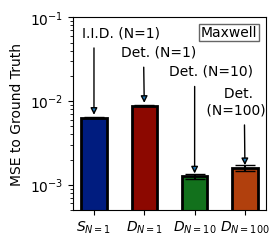

In [155]:
method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][1]

mpldict = yaml.safe_load("""
kind: bar
xcol: Sampling Scheme
# xlabel: Sampling Scheme
xlabel: null
ylabel: MSE to Ground Truth
elements:
  $S_{N=1}$:
    include: [{srfpts/detspc: false}]
    ax.bar/color: blue
    ax.annotate/text: I.I.D. (N=1)
    ax.annotate/xytext: [0.05, 0.9]
    arrowprops/relpos: [0.15, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $D_{N=1}$:
    include: [{srfpts/detspc: true, srfpts/n/trg: 1,    vol/n: 400}]
    ax.bar/color: red
    ax.annotate/text: Det. (N=1)
    ax.annotate/xytext: [0.25, 0.8]
    arrowprops/relpos: [0.3, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $D_{N=10}$:
    include: [{srfpts/detspc: true, srfpts/n/trg: 10,   vol/n:  80}]
    ax.bar/color: green
    ax.annotate/text: Det. (N=10)
    ax.annotate/xytext: [0.5, 0.7]
    arrowprops/relpos: [0.3, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $D_{N=100}$:
    include: [{srfpts/detspc: true, srfpts/n/trg: 100,  vol/n:   8}]
    ax.bar/color: orange
    ax.annotate/text: "     Det.\\n (N=100)"
    ax.annotate/xytext: [0.67, 0.5]
    arrowprops/relpos: [0.66, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.66, 0.9, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/01_mse_vs_sampling.pdf', bbox_inches="tight")

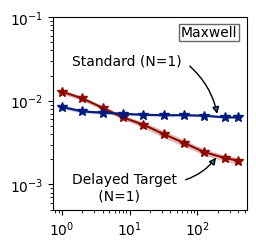

In [157]:
mpldict = yaml.safe_load("""
kind: line
xcol: vol/n
# xlabel: Number of Balls
xlabel: null
ylabel: null
xscale: log
ax.plot/marker: '*'
ax.plot/markersize: 7

# Remove the following two lines for bringing back ylabel and ticks
# yticklabels: []



elements:
  Standard:
    exclude: [{trg/btstrp: true}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=1)"
    ax.annotate/xytext: [0.1, 0.75]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.6]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  Delayed Target:
    exclude: [{trg/btstrp: false}]
    ax.plot/color: red
    ax.annotate/text: "Delayed Target\\n      (N=1)"
    ax.annotate/xytext: [0.1, 0.05]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

aggdf_std = dashdata_mxw['data'][2][2].copy(deep=True)
aggdf_std['trg/btstrp'] = False

aggdf_bts = dashdata_mxw['data'][9][2].copy(deep=True)
aggdf_bts['trg/btstrp'] = True
aggdf_bts['fpidxgrp'] += aggdf_std['fpidx'].max() + 1
aggdf_bts['fpidx'] += aggdf_std['fpidx'].max() + 1

aggdf = pd.concat([aggdf_std, aggdf_bts], axis=0, ignore_index=True)
fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)

bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.66, 0.9, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/02_mse_vs_nballs_method.pdf', bbox_inches="tight")

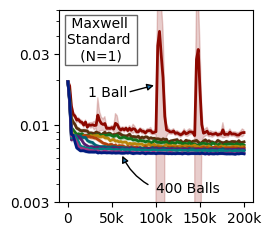

In [605]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
# xlabel: Epoch
xlabel: null
ylabel: null
smry/sel: null
smry/cri: null
ylim: [0.003, 0.06]
yticks: [0.003, 0.01, 0.03]
yticklabels: ["0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2
elements:
  1:
    include: [{vol/n: 1}]
    ax.plot/color: red
    ax.annotate/text: "1 Ball"
    ax.annotate/xytext: [0.15, 0.55]
    ax.annotate/xy: [0.5035, null]
    arrowprops/relpos: [1.0, 0.5]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/connectionstyle: "arc3,rad=0.0"
  2: {include: [{vol/n: 2}], ax.plot/color: brown}
  4: {include: [{vol/n: 4}], ax.plot/color: green}
  8: {include: [{vol/n: 8}], ax.plot/color: yellow}
  16: {include: [{vol/n: 16}], ax.plot/color: orange}
  32: {include: [{vol/n: 32}], ax.plot/color: cyan}
  64: {include: [{vol/n: 64}], ax.plot/color: purple}
  128: {include: [{vol/n: 128}], ax.plot/color: teal}
  256: {include: [{vol/n: 256}], ax.plot/color: pink}
  400:
    include: [{vol/n: 400}]
    ax.plot/color: blue
    ax.annotate/text: "400 Balls"
    ax.annotate/xytext: [0.5, 0.05]
    ax.annotate/xy: [0.32, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][2]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.04, 0.74, ' Maxwell\nStandard \n   (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/03_mse_vs_epoch_nballs_std.pdf', bbox_inches="tight")

#### Figure Batch 2: Ball Center Distribution

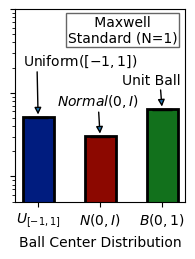

In [116]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Ball Center Distribution
xlabel: Ball Center Distribution
# ylabel: MSE to Ground Truth
ylabel: null
yticklabels: []
figsize: [2.2, 2.5]
elements:
  $U_{[-1, 1]}$:
    include: [{vol/c/dstr: uniform, vol/c/low: "[-1.0]", vol/c/high: "[1.0]"}]
    ax.bar/color: blue
    ax.annotate/text: Uniform$([-1, 1])$
    ax.annotate/xytext: [0.05, 0.71]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.12, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $N(0,I)$:
    include: [{vol/c/dstr: normal, vol/c/loc: "[0.0]", vol/c/scale: 1.0}]
    ax.bar/color: red
    ax.annotate/text: $Normal(0, I)$
    ax.annotate/xytext: [0.25, 0.5]
    arrowprops/relpos: [0.5, 0.0]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $B(0,1)$:
    include: [{vol/c/dstr: ball, vol/c/c: "[0.0]", vol/c/r: 1.0}]
    ax.bar/color: green
    ax.annotate/text: Unit Ball
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    ax.annotate/xytext: [0.63, 0.61]
    arrowprops/relpos: [0.65, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][3]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.31, 0.83, '      Maxwell\nStandard (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/04_mse_vs_ballc_std.pdf', bbox_inches="tight")

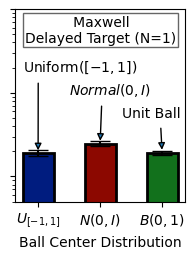

In [129]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Ball Center Distribution
xlabel: Ball Center Distribution
ylabel: MSE to Ground Truth

figsize: [2.2, 2.5]
# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  $U_{[-1, 1]}$:
    include: [{vol/c/dstr: uniform, vol/c/low: "[-1.0]", vol/c/high: "[1.0]"}]
    ax.bar/color: blue
    ax.annotate/text: Uniform$([-1, 1])$
    ax.annotate/xytext: [0.05, 0.68]
    arrowprops/relpos: [0.13, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $N(0,I)$:
    include: [{vol/c/dstr: normal, vol/c/loc: "[0.0]", vol/c/scale: 1.0}]
    ax.bar/color: red
    ax.annotate/text: $Normal(0, I)$
    ax.annotate/xytext: [0.32, 0.56]
    arrowprops/relpos: [0.4, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $B(0,1)$:
    include: [{vol/c/dstr: ball, vol/c/c: "[0.0]", vol/c/r: 1.0}]
    ax.bar/color: green
    ax.annotate/text: Unit Ball
    ax.annotate/xytext: [0.63, 0.44]
    arrowprops/relpos: [0.65, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][10]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.06, 0.83, '           Maxwell\nDelayed Target (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/05_mse_vs_ballc_bts.pdf', bbox_inches="tight")

#### Figure Batch 3: Ball Radius Distribution

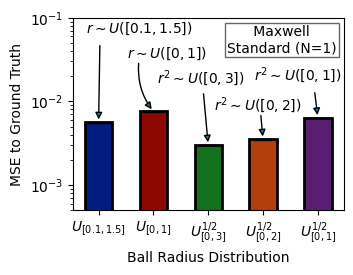

In [140]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Ball Radius Distribution
xlabel: Ball Radius Distribution
ylabel: MSE to Ground Truth
figsize: [3.5, 2.5]
elements:
  $U_{[0.1, 1.5]}$:
    include: [{vol/r/dstr: uniform, vol/r/low: 0.1, vol/r/high: 1.5}]
    ax.bar/color: blue
    ax.annotate/text: $r\sim U([0.1,1.5])$
    ax.annotate/xytext: [0.05, 0.92]
    arrowprops/relpos: [0.13, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U_{[0,1]}$:
    include: [{vol/r/dstr: uniform, vol/r/low: 0.0, vol/r/high: 1}]
    ax.bar/color: red
    ax.annotate/text: $r\sim U([0,1])$
    ax.annotate/xytext: [0.2, 0.79]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.15, 0.1]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  $U^{1/2}_{[0,3]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: "sqrt(dim+1)"}]
    ax.bar/color: green
    ax.annotate/text: $r^2\sim U([0,3])$
    ax.annotate/xytext: [0.31, 0.66]
    arrowprops/relpos: [0.53, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U^{1/2}_{[0,2]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: "sqrt(dim)"}]
    ax.bar/color: orange
    ax.annotate/text: $r^2\sim U([0,2])$
    ax.annotate/xytext: [0.52, 0.52]
    arrowprops/relpos: [0.54, -0.02]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U^{1/2}_{[0,1]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: 1}]
    ax.bar/color: purple
    ax.annotate/text: $r^2\sim U([0,1])$
    ax.annotate/xytext: [0.67, 0.68]
    arrowprops/relpos: [0.68, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][4]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.57, 0.82, '      Maxwell\nStandard (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/06_mse_vs_ballr_std.pdf', bbox_inches="tight")

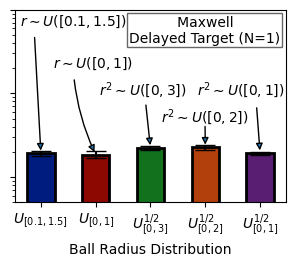

In [152]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Ball Radius Distribution
xlabel: Ball Radius Distribution
ylabel: MSE to Ground Truth
figsize: [3.5, 2.5]

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  $U_{[0.1, 1.5]}$:
    include: [{vol/r/dstr: uniform, vol/r/low: 0.1, vol/r/high: 1.5}]
    ax.bar/color: blue
    ax.annotate/text: $r\sim U([0.1,1.5])$
    ax.annotate/xytext: [0.02, 0.92]
    arrowprops/relpos: [0.13, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U_{[0,1]}$:
    include: [{vol/r/dstr: uniform, vol/r/low: 0.0, vol/r/high: 1}]
    ax.bar/color: red
    ax.annotate/text: $r\sim U([0,1])$
    ax.annotate/xytext: [0.14, 0.70]
    arrowprops/relpos: [0.25, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.1"
  $U^{1/2}_{[0,3]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: "sqrt(dim+1)"}]
    ax.bar/color: green
    ax.annotate/text: $r^2\sim U([0,3])$
    ax.annotate/xytext: [0.31, 0.56]
    arrowprops/relpos: [0.53, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U^{1/2}_{[0,2]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: "sqrt(dim)"}]
    ax.bar/color: orange
    ax.annotate/text: $r^2\sim U([0,2])$
    ax.annotate/xytext: [0.54, 0.42]
    arrowprops/relpos: [0.5, 0.0]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $U^{1/2}_{[0,1]}$:
    include: [{vol/r/dstr: unifdpow, vol/r/low: 0.0, vol/r/high: 1}]
    ax.bar/color: purple
    ax.annotate/text: $r^2\sim U([0,1])$
    ax.annotate/xytext: [0.67, 0.56]
    arrowprops/relpos: [0.68, 0.0]
    arrowprops/connectionstyle: "arc3,rad=-0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][11]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.42, 0.83, '           Maxwell\nDelayed Target (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/07_mse_vs_ballr_bts.pdf', bbox_inches="tight")

#### Figure Batch 4: Function Approximation

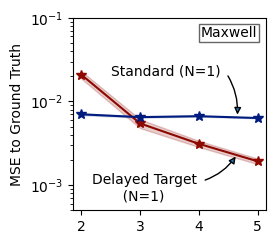

In [163]:
mpldict = yaml.safe_load("""
kind: line
xcol: nn/hidden
# xlabel: Neural Network Depth
ylabel: MSE to Ground Truth
xlabel: null
xscale: linear
ax.plot/marker: '*'
ax.plot/markersize: 7
xticks: [1, 2, 3, 4]
xticklabels: [2, 3, 4, 5]
elements:
  Standard:
    include: [{trg/btstrp: false}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=1)"
    ax.annotate/xytext: [0.2, 0.7]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.9]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  Delayed Target:
    include: [{trg/btstrp: true}]
    ax.plot/color: red
    ax.annotate/text: "Delayed Target\\n       (N=1)"
    ax.annotate/xytext: [0.1, 0.05]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

aggdf_std = dashdata_mxw['data'][6][2].copy(deep=True)
aggdf_std = aggdf_std.sort_values(by=['nn/hidden', 'fpidxgrp'])
aggdf_std['trg/btstrp'] = False

aggdf_bts = dashdata_mxw['data'][12][2].copy(deep=True)
aggdf_bts['trg/btstrp'] = True
aggdf_bts['fpidxgrp'] += aggdf_std['fpidx'].max()+1
aggdf_bts['fpidx'] += aggdf_std['fpidx'].max()+1

aggdf = pd.concat([aggdf_std, aggdf_bts], axis=0, ignore_index=True)
fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)

bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.66, 0.9, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/08_mse_vs_depth_method.pdf', bbox_inches="tight")

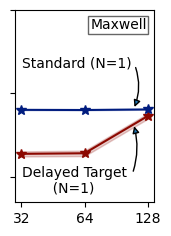

In [168]:
mpldict = yaml.safe_load("""
kind: line
xcol: nn/width
# xlabel: Neural Network Width
xlabel: null
xscale: log
ax.plot/marker: '*'
ax.plot/markersize: 7
xticks: [32, 64, 128]
xticklabels: ["32", "64", "128"]

figsize: [1.8, 2.5]

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  Standard:
    include: [{trg/btstrp: false}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=1)"
    ax.annotate/xytext: [0.05, 0.7]
    ax.annotate/xy: [0.85, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.03, 0.4]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  Delayed Target:
    include: [{trg/btstrp: true}]
    ax.plot/color: red
    ax.annotate/text: "Delayed Target\\n       (N=1)"
    ax.annotate/xytext: [0.05, 0.05]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.3]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

aggdf_std = dashdata_mxw['data'][5][2].copy(deep=True)
aggdf_std['trg/btstrp'] = False

aggdf_bts = dashdata_mxw['data'][14][2].copy(deep=True)
aggdf_bts['trg/btstrp'] = True
aggdf_bts['fpidxgrp'] += aggdf_std['fpidx'].max()+1
aggdf_bts['fpidx'] += aggdf_std['fpidx'].max()+1

aggdf = pd.concat([aggdf_std, aggdf_bts], axis=0, ignore_index=True)
fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.54, 0.9, 'Maxwell', transform=ax.transAxes, bbox=bbox)

ax.minorticks_off()

fig.savefig(f'{maxwelldir}/09_mse_vs_width_method.pdf', bbox_inches="tight")

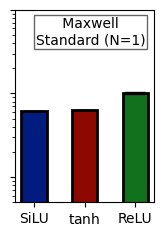

In [176]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Activation Function
# xlabel: Activation Function
xlabel: null
ylabel: MSE to Ground Truth

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

figsize: [1.8, 2.5]
elements:
  SiLU:
    include: [{nn/act: silu}]
    ax.bar/color: blue
    # ax.annotate/text: SiLU
    # ax.annotate/xytext: [0.05, 0.92]
    # arrowprops/relpos: [0.5, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  $\\tanh$:
    include: [{nn/act: tanh}]
    ax.bar/color: red
    # ax.annotate/text: $\\tanh$
    # ax.annotate/xytext: [0.42, 0.83]
    # arrowprops/relpos: [0.5, 0.5]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  ReLU:
    include: [{nn/act: relu}]
    ax.bar/color: green
    # ax.annotate/text: ReLU
    # ax.annotate/xytext: [0.73, 0.75]
    # arrowprops/relpos: [0.48, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][7]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.15, 0.82, '      Maxwell\nStandard (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/10_mse_vs_act_std.pdf', bbox_inches="tight")

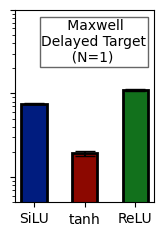

In [186]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Activation Function
xlabel: Activation Function
ylabel: MSE to Ground Truth

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null
xlabel: null

figsize: [1.8, 2.5]
elements:
  SiLU:
    include: [{nn/act: silu}]
    ax.bar/color: blue
    # ax.annotate/text: SiLU
    # ax.annotate/xytext: [0.05, 0.8]
    # arrowprops/relpos: [0.5, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  $\\tanh$:
    include: [{nn/act: tanh}]
    ax.bar/color: red
    # ax.annotate/text: $\\tanh$
    # ax.annotate/xytext: [0.41, 0.6]
    # arrowprops/relpos: [0.5, 0.5]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  ReLU:
    include: [{nn/act: relu}]
    ax.bar/color: green
    # ax.annotate/text: ReLU
    # ax.annotate/xytext: [0.73, 0.9]
    # arrowprops/relpos: [0.5, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][13]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.19, 0.73, '      Maxwell\nDelayed Target\n       (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/11_mse_vs_act_bts.pdf', bbox_inches="tight")

#### Figure Batch 5: Function Approximation Training Curves

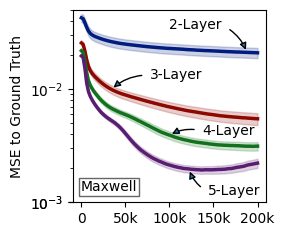

In [196]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
# xlabel: Epoch
xlabel: null
smry/sel: null
smry/cri: null
ylim: [0.001, 0.05]
yticks: [0.001, 0.001, 0.01]
# yticklabels: ["0.0001", "0.0003", "0.001", "0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2.5
elements:
  1:
    include: [{nn/hidden: 1}]
    ax.plot/color: blue
    ax.annotate/text: "2-Layer"
    ax.annotate/xytext: [0.5, 0.9]
    ax.annotate/xy: [0.9, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  2:
    include: [{nn/hidden: 2}]
    ax.plot/color: red
    ax.annotate/text: "3-Layer"
    ax.annotate/xytext: [0.4, 0.64]
    ax.annotate/xy: [0.2, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  3:
    include: [{nn/hidden: 3}]
    ax.plot/color: green
    ax.annotate/text: "4-Layer"
    ax.annotate/xytext: [0.67, 0.35]
    ax.annotate/xy: [0.5, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  4:
    include: [{nn/hidden: 4}]
    ax.plot/color: purple
    ax.annotate/text: "5-Layer"
    ax.annotate/xytext: [0.7, 0.04]
    ax.annotate/xy: [0.6, null]
    arrowprops/relpos: [0.0, 0.4]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][12]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.04, 0.06, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/12_mse_vs_epoch_depth_bts.pdf', bbox_inches="tight")

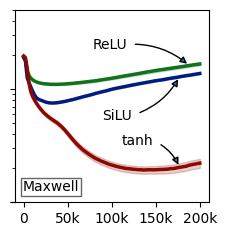

In [197]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
# xlabel: Epoch
xlabel: null
smry/sel: null
smry/cri: null
ylim: [0.001, 0.05]
yticks: [0.001, 0.001, 0.01]
# yticklabels: ["0.0001", "0.0003", "0.001", "0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2.5

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  silu:
    include: [{nn/act: silu}]
    ax.plot/color: blue
    ax.annotate/text: SiLU
    ax.annotate/xytext: [0.45, 0.43]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  tanh:
    include: [{nn/act: tanh}]
    ax.plot/color: red
    ax.annotate/text: "tanh"
    ax.annotate/xytext: [0.55, 0.3]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  relu:
    include: [{nn/act: relu}]
    ax.plot/color: green
    ax.annotate/text: ReLU
    ax.annotate/xytext: [0.4, 0.8]
    ax.annotate/xy: [0.9, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][13]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.04, 0.06, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/13_mse_vs_epoch_act_bts.pdf', bbox_inches="tight")

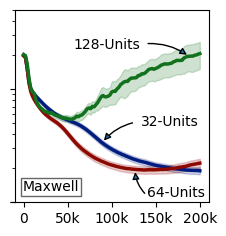

In [586]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
ylim: [0.001, 0.05]
yticks: [0.001, 0.001, 0.01]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2.5

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null
xlabel: null

elements:
  32:
    include: [{nn/width: 32}]
    ax.plot/color: blue
    ax.annotate/text: "32-Units"
    ax.annotate/xytext: [0.65, 0.4]
    ax.annotate/xy: [0.45, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  64:
    include: [{nn/width: 64}]
    ax.plot/color: red
    ax.annotate/text: "64-Units"
    ax.annotate/xytext: [0.68, 0.03]
    ax.annotate/xy: [0.62, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.0, 0.3]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  128:
    include: [{nn/width: 128}]
    ax.plot/color: green
    ax.annotate/text: "128-Units"
    ax.annotate/xytext: [0.3, 0.8]
    ax.annotate/xy: [0.9, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][14]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.04, 0.06, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/14_mse_vs_epoch_width_bts.pdf', bbox_inches="tight")

#### Figure Batch 6: Delayed Targeting

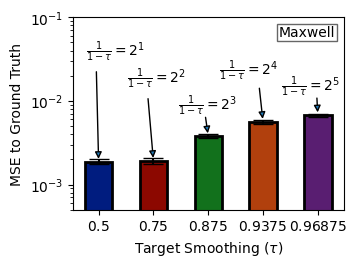

In [233]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Target Smoothing ($\\tau$)
xlabel: Target Smoothing ($\\tau$)
# xlabel: null
ylabel: MSE to Ground Truth
figsize: [3.5, 2.5]
elements:
  $0.5$:
    include: [{trg/tau: 0.5}]
    ax.bar/color: blue
    ax.annotate/text: $\\frac{1}{1-\\tau}=2^1$
    ax.annotate/xytext: [0.05, 0.8]
    arrowprops/relpos: [0.17, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.75$:
    include: [{trg/tau: 0.75}]
    ax.bar/color: red
    ax.annotate/text: $\\frac{1}{1-\\tau}=2^2$
    ax.annotate/xytext: [0.2, 0.66]
    arrowprops/relpos: [0.33, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.875$:
    include: [{trg/tau: 0.875}]
    ax.bar/color: green
    ax.annotate/text: $\\frac{1}{1-\\tau}=2^3$
    ax.annotate/xytext: [0.39, 0.52]
    arrowprops/relpos: [0.46, 0.0]
    arrowprops/shrinkA: 0
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.9375$:
    include: [{trg/tau: 0.9375}]
    ax.bar/color: orange
    ax.annotate/text: $\\frac{1}{1-\\tau}=2^4$
    ax.annotate/xytext: [0.54, 0.7]
    arrowprops/relpos: [0.67, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.96875$:
    include: [{trg/tau: 0.96875}]
    ax.bar/color: purple
    ax.annotate/text: $\\frac{1}{1-\\tau}=2^5$
    ax.annotate/xytext: [0.77, 0.62]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.6, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][15]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.76, 0.9, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/15_mse_vs_tau.pdf', bbox_inches="tight")

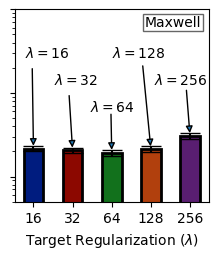

In [232]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Target Regularization ($\\lambda$)
xlabel: Target Regularization ($\\lambda$)
ylabel: MSE to Ground Truth

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null
# xlabel: null
xticklabels: ["64", "128", "256", "32", "16"]

elements:
  16:
    include: [{trg/reg/w: 16}]
    ax.bar/color: blue
    ax.annotate/text: $\\lambda=16$
    ax.annotate/xytext: [0.05, 0.75]
    arrowprops/relpos: [0.17, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  32:
    include: [{trg/reg/w: 32}]
    ax.bar/color: red
    ax.annotate/text: $\\lambda=32$
    ax.annotate/xytext: [0.2, 0.61]
    arrowprops/relpos: [0.33, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  64:
    include: [{trg/reg/w: 64}]
    ax.bar/color: green
    ax.annotate/text: $\\lambda=64$
    ax.annotate/xytext: [0.39, 0.47]
    arrowprops/relpos: [0.46, 0.0]
    arrowprops/shrinkA: 0
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/connectionstyle: "arc3,rad=0.0"
  128:
    include: [{trg/reg/w: 128}]
    ax.bar/color: orange
    ax.annotate/text: $\\lambda=128$
    ax.annotate/xytext: [0.5, 0.75]
    arrowprops/relpos: [0.57, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  256:
    include: [{trg/reg/w: 256}]
    ax.bar/color: purple
    ax.annotate/text: $\\lambda=256$
    ax.annotate/xytext: [0.72, 0.61]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.6, -0.2]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][16]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.67, 0.91, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/16_mse_vs_lambda.pdf', bbox_inches="tight")

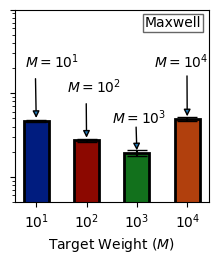

In [231]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Target Weight ($M$)
xlabel: Target Weight ($M$)
ylabel: MSE to Ground Truth
figsize: [2.5, 2.5]

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null
# xlabel: null

elements:
  $10^1$:
    include: [{trg/w: 0.9}]
    ax.bar/color: blue
    ax.annotate/text: $M=10^1$
    ax.annotate/xytext: [0.05, 0.7]
    arrowprops/relpos: [0.2, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $10^2$:
    include: [{trg/w: 0.99}]
    ax.bar/color: red
    ax.annotate/text: $M=10^2$
    ax.annotate/xytext: [0.27, 0.57]
    arrowprops/relpos: [0.35, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $10^3$:
    include: [{trg/w: 0.999}]
    ax.bar/color: green
    ax.annotate/text: $M=10^3$
    ax.annotate/xytext: [0.5, 0.41]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.45, -0.05]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $10^4$:
    include: [{trg/w: 0.9999}]
    ax.bar/color: orange
    ax.annotate/text: $M=10^4$
    ax.annotate/xytext: [0.72, 0.7]
    arrowprops/relpos: [0.6, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][17]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.67, 0.91, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/17_mse_vs_trgw.pdf', bbox_inches="tight")

#### Figure Batch 7: Learning Rate

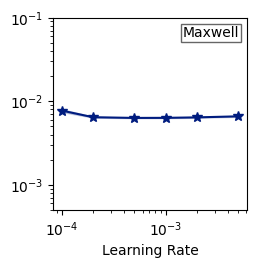

In [237]:
mpldict = yaml.safe_load("""
kind: line
xcol: opt/lr
xlabel: Learning Rate
xscale: log
ax.plot/marker: '*'
ax.plot/markersize: 7

# Remove the following two lines for bringing back ylabel and ticks
# xticks: [0.0001, 0.0003, 0.001, 0.003]
# xticklabels: ["$10^{-4}$", "$3 \\\\times 10^{-4}$", "$10^{-3}$", "$3 \\\\times 10^{-3}$"]
xticks: [0.0001, 0.001]
xticklabels: ["$10^{-4}$", "$10^{-3}$"]
ylabel: null

elements:
  Standard:
    ax.plot/color: blue
    # ax.annotate/text: "Standard (N=1)"
    # ax.annotate/xytext: [0.1, 0.8]
    # ax.annotate/xy: [0.85, null]
    # arrowprops/relpos: [1.0, 0.6]
    # arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

aggdf = dashdata_mxw['data'][8][2].copy(deep=True)
fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.67, 0.90, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/18_mse_vs_lr_std.pdf', bbox_inches="tight")

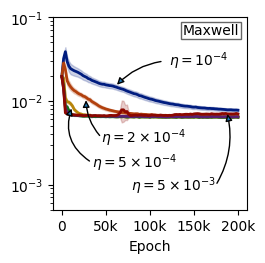

In [245]:
mpldict = yaml.safe_load(r"""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
# ylim: [0.003, 0.06]
# yticks: [0.003, 0.01, 0.03]
# yticklabels: ["0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2
ylabel: null
elements:
  0.005:
    include: [{opt/lr: 0.005}]
    ax.plot/color: red
    ax.annotate/text: "$\\eta=5\\times 10^{-3}$"
    ax.annotate/xytext: [0.4, 0.1]
    ax.annotate/xy: [0.90, null]
    arrowprops/relpos: [1.0, 0.5]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkB: 0
    arrowprops/connectionstyle: "arc3,rad=0.2"
  0.002: {include: [{opt/lr: 0.002}], ax.plot/color: purple}
  0.001: {include: [{opt/lr: 0.001}], ax.plot/color: green}
  0.0005: 
    include: [{opt/lr: 0.0005}]
    ax.plot/color: yellow
    ax.annotate/text: "$\\eta=5\\times 10^{-4}$"
    ax.annotate/xytext: [0.2, 0.22]
    bbox/pad: 90
    bbox/edgecolor: none
    bbox/facecolor: none
    ax.annotate/xy: [0.10, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.4"
  0.0002: 
    include: [{opt/lr: 0.0002}]
    ax.plot/color: orange
    ax.annotate/text: "$\\eta=2\\times 10^{-4}$"
    ax.annotate/xytext: [0.25, 0.35]
    bbox/pad: 90
    bbox/edgecolor: none
    bbox/facecolor: none
    ax.annotate/xy: [0.17, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  0.0001:
    include: [{opt/lr: 0.0001}]
    ax.plot/color: blue
    ax.annotate/text: "$\\eta=10^{-4}$"
    ax.annotate/xytext: [0.6, 0.75]
    ax.annotate/xy: [0.32, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_mxw['data'][8]

fig, ax = draw_matplotlib({**mplglbls_mxw, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.67, 0.91, 'Maxwell', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{maxwelldir}/19_mse_vs_epoch_lr_std.pdf', bbox_inches="tight")

## The Smoluchowski Problems

### The Training Curves Dashboard

In [4]:
smrypath = f'../summary/21_smoluchowski.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
data_ = hie2deep(data, maxdepth=1)
dfd_bts = data_['bts']
dfd_mse = data_['mse']
dfd_mselr = data_['mselr']
hpdf_mse = dfd_mse['hp']
statdf_mse = dfd_mse['stat']
hpdf_bts = dfd_bts['hp']
statdf_bts = dfd_bts['stat']
hpdf_mselr = dfd_mselr['hp']
statdf_mselr = dfd_mselr['stat']

Disk usage for "../summary/21_smoluchowski.h5"
mselr/hp                                                                          4.454 MB
bts/hp                                                                           14.454 MB
mse/hp                                                                           21.423 MB
bts/stat                                                                         31.512 MB
mselr/stat                                                                        9.696 MB
mse/stat                                                                         35.552 MB
------------------------------------------------------------------------------------------
Total                                                                             0.117 GB


In [5]:
ymlpath = f'{workdir}/02_smoluchowski.yml'
data = [('Standard Training', hpdf_mse, statdf_mse),
        ('Bootstrapping',     hpdf_bts, statdf_bts)]

dashdata = get_dashdata(data, ymlpath, write_yml=False)

In [6]:
fulllayout = build_dashboard(None, **dashdata)
output_file(f'{workdir}/02_smoluchowski.html')
save(fulllayout, title=dashdata['header'])

'/code_bspinn/notebook/29_plotting/02_smoluchowski.html'

### The Supplementary Figures

In [9]:
smrypath = f'../summary/21_smoluchowski.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
data_ = hie2deep(data, maxdepth=1)
dfd_bts = data_['bts']
dfd_mse = data_['mse']
dfd_mselr = data_['mselr']
hpdf_mse = dfd_mse['hp']
statdf_mse = dfd_mse['stat']
hpdf_bts = dfd_bts['hp']
statdf_bts = dfd_bts['stat']
hpdf_mselr = dfd_mselr['hp']
statdf_mselr = dfd_mselr['stat']

Disk usage for "../summary/21_smoluchowski.h5"
mselr/hp                                                                          4.454 MB
bts/hp                                                                           14.454 MB
mse/hp                                                                           21.423 MB
bts/stat                                                                         31.512 MB
mselr/stat                                                                        9.696 MB
mse/stat                                                                         35.552 MB
------------------------------------------------------------------------------------------
Total                                                                             0.117 GB


In [10]:
ymlpath = f'{workdir}/02_smoluchowski.yml'
data = [('Standard Training', hpdf_mse, statdf_mse),
        ('Bootstrapping',     hpdf_bts, statdf_bts)]

dashdata_smol = get_dashdata(data, ymlpath, write_yml=False)

smoldir = f'{suppdir}/02_smoluchowski'
! mkdir -p {smoldir}

In [11]:
mplglbls_smol = ruyaml.safe_load("""
  ycol: MSE to Ground Truth (IID)
  ylabel: MSE to Ground Truth
  figsize: [2.5, 2.5]
  smry/sel: MSE to Ground Truth (IID)/mean
  smry/cri: min
  colorspec: 
    blue: '#001c7f'
    orange: '#b1400d'
    green: '#12711c'
    red: '#8c0800'
    purple: '#591e71'
    brown: '#592f0d'
    pink: '#a23582'
    gray: '#3c3c3c'
    yellow: '#b8850a'
    cyan: '#006374'
    black: '#000000'
  yscale: log
  ax.bar/capsize: 7
  ax.bar/ecolor: black
  ax.bar/edgecolor: black
  ax.bar/linewidth: 2.0
  ax.bar/log: true
  ax.bar/width: 0.5
  arrowprops/arrowstyle: "-|>"
  ax.annotate/xycoords: axes fraction 
  ax.annotate/textcoords: axes fraction
  ylim: [5e-4, 1e1]
  yticks: null
  yticklabels: null
  xticks: null
  ylabelpad: null
""")

#### Figure Batch 1: Sampling Scheme

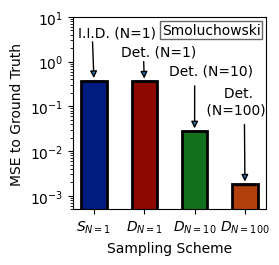

In [254]:
method, ablname, aggdf, hpcols, stcols, _ = dashdata_smol['data'][4]

mpldict = yaml.safe_load("""
kind: bar
xcol: Sampling Scheme
xlabel: Sampling Scheme
ylabel: MSE to Ground Truth
elements:
  $S_{N=1}$:
    include: [{pts/detspc: false}]
    ax.bar/color: blue
    ax.annotate/text: I.I.D. (N=1)
    ax.annotate/xytext: [0.03, 0.9]
    bbox/pad: 90
    bbox/edgecolor: none
    bbox/facecolor: none
    arrowprops/relpos: [0.18, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $D_{N=1}$:
    include: [{pts/detspc: true, pts/n: 1,    eq/n: 400}]
    ax.bar/color: red
    ax.annotate/text: Det. (N=1)
    ax.annotate/xytext: [0.25, 0.8]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.3, -0.03]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $D_{N=10}$:
    include: [{pts/detspc: true, pts/n: 10,   eq/n:  40}]
    ax.bar/color: green
    ax.annotate/text: Det. (N=10)
    ax.annotate/xytext: [0.5, 0.7]
    arrowprops/relpos: [0.3, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
#   $D_{N=20}$:
#     include: [{pts/detspc: true, pts/n: 20,  eq/n:   20}]
#     ax.bar/color: purple
#     ax.annotate/text: "     Det.\\n (N=20)"
#     ax.annotate/xytext: [0.67, 0.5]
#     arrowprops/relpos: [0.66, 0.0]
#     arrowprops/connectionstyle: "arc3,rad=0.0"
  $D_{N=100}$:
    include: [{pts/detspc: true, pts/n: 100,  eq/n:   4}]
    ax.bar/color: orange
    ax.annotate/text: "     Det.\\n (N=100)"
    ax.annotate/xytext: [0.67, 0.5]
    arrowprops/relpos: [0.66, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.46, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/01_mse_vs_sampling.pdf', bbox_inches="tight")

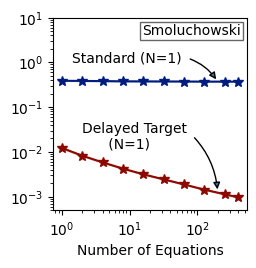

In [262]:
mpldict = yaml.safe_load("""
kind: line
xcol: eq/n
xlabel: Number of Equations
xscale: log
ax.plot/marker: '*'
ax.plot/markersize: 7
# ylim: [1e-4, 1e1]

# Remove the following two lines for bringing back ylabel and ticks
# yticklabels: []
ylabel: null

elements:
  Standard:
    exclude: [{trg/btstrp: true}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=1)"
    ax.annotate/xytext: [0.1, 0.77]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.6]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  Delayed Target:
    exclude: [{trg/btstrp: false}]
    ax.plot/color: red
    ax.annotate/text: "Delayed Target\\n      (N=1)"
    ax.annotate/xytext: [0.15, 0.32]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

aggdf_std = dashdata_smol['data'][3][2].copy(deep=True)
aggdf_std['trg/btstrp'] = False

aggdf_bts = dashdata_smol['data'][12][2].copy(deep=True)
aggdf_bts['trg/btstrp'] = True
aggdf_bts['fpidxgrp'] += aggdf_std['fpidx'].max() + 1
aggdf_bts['fpidx'] += aggdf_std['fpidx'].max() + 1

aggdf = pd.concat([aggdf_std, aggdf_bts], axis=0, ignore_index=True)
fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.46, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/02_mse_vs_nballs_method.pdf', bbox_inches="tight")

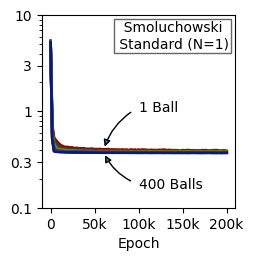

In [261]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
xlabel: Epoch
ylabel: null
smry/sel: null
smry/cri: null
ylim: [0.1, 10]
yticks: [0.1, 0.3, 1, 3, 10]
yticklabels: ["0.1", "0.3", "1", "3", "10"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2
elements:
  1:
    include: [{eq/n: 1}]
    ax.plot/color: red
    ax.annotate/text: "1 Ball"
    ax.annotate/xytext: [0.5, 0.5]
    ax.annotate/xy: [0.32, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  2: {include: [{eq/n: 2}], ax.plot/color: brown}
  4: {include: [{eq/n: 4}], ax.plot/color: green}
  8: {include: [{eq/n: 8}], ax.plot/color: yellow}
  16: {include: [{eq/n: 16}], ax.plot/color: orange}
  32: {include: [{eq/n: 32}], ax.plot/color: cyan}
  64: {include: [{eq/n: 64}], ax.plot/color: purple}
  128: {include: [{eq/n: 128}], ax.plot/color: teal}
  256: {include: [{eq/n: 256}], ax.plot/color: pink}
  400:
    include: [{eq/n: 400}]
    ax.plot/color: blue
    ax.annotate/text: "400 Balls"
    ax.annotate/xytext: [0.5, 0.1]
    ax.annotate/xy: [0.32, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_smol['data'][3]

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.38, 0.83, '  Smoluchowski\n Standard (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/03_mse_vs_epoch_neqs_std.pdf', bbox_inches="tight")

#### Figure Batch 2: Function Approximation

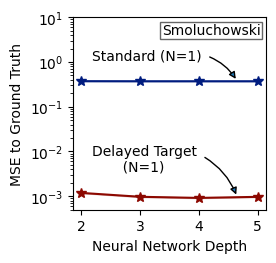

In [264]:
mpldict = yaml.safe_load("""
kind: line
xcol: nn/hidden
xlabel: Neural Network Depth
xscale: linear
ax.plot/marker: '*'
ax.plot/markersize: 7
xticks: [1, 2, 3, 4]
xticklabels: [2, 3, 4, 5]
elements:
  Standard:
    include: [{trg/btstrp: false}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=1)"
    ax.annotate/xytext: [0.1, 0.78]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.6]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  Delayed Target:
    include: [{trg/btstrp: true}]
    ax.plot/color: red
    ax.annotate/text: "Delayed Target\\n       (N=1)"
    ax.annotate/xytext: [0.1, 0.2]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.7]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

aggdf_std = dashdata_smol['data'][5][2].copy(deep=True)
aggdf_std = aggdf_std.sort_values(by=['nn/hidden', 'fpidxgrp'])
aggdf_std['trg/btstrp'] = False

aggdf_bts = dashdata_smol['data'][14][2].copy(deep=True)
aggdf_bts['trg/btstrp'] = True
aggdf_bts['fpidxgrp'] += aggdf_std['fpidx'].max()+1
aggdf_bts['fpidx'] += aggdf_std['fpidx'].max()+1

aggdf = pd.concat([aggdf_std, aggdf_bts], axis=0, ignore_index=True)
fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.46, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/04_mse_vs_depth_method.pdf', bbox_inches="tight")

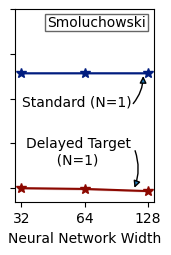

In [275]:
mpldict = yaml.safe_load("""
kind: line
xcol: nn/width
xlabel: Neural Network Width
xscale: log
ax.plot/marker: '*'
ax.plot/markersize: 7
xticks: [32, 64, 128]
xticklabels: ["32", "64", "128"]

figsize: [1.8, 2.5]

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  Standard:
    include: [{trg/btstrp: false}]
    ax.plot/color: blue
    ax.annotate/text: "Standard (N=1)"
    ax.annotate/xytext: [0.05, 0.5]
    ax.annotate/xy: [0.92, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.0, 0.2]
    arrowprops/connectionstyle: "arc3,rad=0.2"
  Delayed Target:
    include: [{trg/btstrp: true}]
    ax.plot/color: red
    ax.annotate/text: "Delayed Target\\n       (N=1)"
    ax.annotate/xytext: [0.08, 0.2]
    ax.annotate/xy: [0.85, null]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [1.03, 0.6]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

aggdf_std = dashdata_smol['data'][6][2].copy(deep=True)
aggdf_std['trg/btstrp'] = False

aggdf_bts = dashdata_smol['data'][15][2].copy(deep=True)
aggdf_bts['trg/btstrp'] = True
aggdf_bts['fpidxgrp'] += aggdf_std['fpidx'].max()+1
aggdf_bts['fpidx'] += aggdf_std['fpidx'].max()+1

aggdf = pd.concat([aggdf_std, aggdf_bts], axis=0, ignore_index=True)
fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.23, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

ax.minorticks_off()

fig.savefig(f'{smoldir}/05_mse_vs_width_method.pdf', bbox_inches="tight")

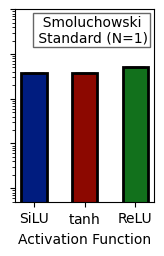

In [279]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Activation Function
xlabel: Activation Function
ylabel: MSE to Ground Truth

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

figsize: [1.8, 2.5]
elements:
  SiLU:
    include: [{nn/act: silu}]
    ax.bar/color: blue
    # ax.annotate/text: SiLU
    # ax.annotate/xytext: [0.05, 0.92]
    # arrowprops/relpos: [0.5, 0.0]
    # bbox/pad: 1
    # bbox/facecolor: none
    # bbox/edgecolor: none
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  $\\tanh$:
    include: [{nn/act: tanh}]
    ax.bar/color: red
    # ax.annotate/text: $\\tanh$
    # ax.annotate/xytext: [0.42, 0.88]
    # arrowprops/relpos: [0.5, 0.5]
    # bbox/pad: 1
    # bbox/facecolor: none
    # bbox/edgecolor: none
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  ReLU:
    include: [{nn/act: relu}]
    ax.bar/color: green
    # ax.annotate/text: ReLU
    # ax.annotate/xytext: [0.73, 0.84]
    # arrowprops/relpos: [0.48, 0.0]
    # bbox/pad: 1
    # bbox/facecolor: none
    # bbox/edgecolor: none
    # arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_smol['data'][7]

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.14, 0.83, '  Smoluchowski\n Standard (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/06_mse_vs_act_std.pdf', bbox_inches="tight")

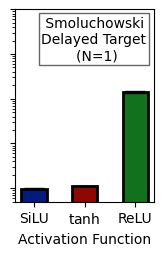

In [297]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Activation Function
xlabel: Activation Function
ylabel: MSE to Ground Truth

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

figsize: [1.8, 2.5]
elements:
  SiLU:
    include: [{nn/act: silu}]
    ax.bar/color: blue
    # ax.annotate/text: SiLU
    # ax.annotate/xytext: [0.05, 0.4]
    # arrowprops/relpos: [0.5, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  $\\tanh$:
    include: [{nn/act: tanh}]
    ax.bar/color: red
    # ax.annotate/text: $\\tanh$
    # ax.annotate/xytext: [0.41, 0.3]
    # arrowprops/relpos: [0.5, 0.5]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
  ReLU:
    include: [{nn/act: relu}]
    ax.bar/color: green
    # ax.annotate/text: ReLU
    # ax.annotate/xytext: [0.73, 0.8]
    # arrowprops/relpos: [0.5, 0.0]
    # arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_smol['data'][16]

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=2.0, alpha=0.6)
ax.text(0.19, 0.74, ' Smoluchowski\nDelayed Target\n        (N=1)', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/07_mse_vs_act_bts.pdf', bbox_inches="tight")

#### Figure Batch 3: Function Approximation Training Curves

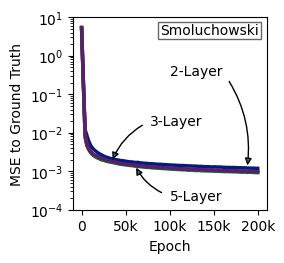

In [300]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
ylim: [0.0001, 10.0]
yticks: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
# yticklabels: ["0.0001", "0.0003", "0.001", "0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2.5
elements:
  1:
    include: [{nn/hidden: 1}]
    ax.plot/color: blue
    ax.annotate/text: "2-Layer"
    ax.annotate/xytext: [0.5, 0.7]
    ax.annotate/xy: [0.9, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  2:
    include: [{nn/hidden: 2}]
    ax.plot/color: red
    ax.annotate/text: "3-Layer"
    ax.annotate/xytext: [0.4, 0.44]
    ax.annotate/xy: [0.2, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  3: {include: [{nn/hidden: 3}], ax.plot/color: green}
  4:
    include: [{nn/hidden: 4}]
    ax.plot/color: purple
    ax.annotate/text: "5-Layer"
    ax.annotate/xytext: [0.5, 0.05]
    ax.annotate/xy: [0.32, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_smol['data'][14]

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.45, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/08_mse_vs_epoch_depth_bts.pdf', bbox_inches="tight")

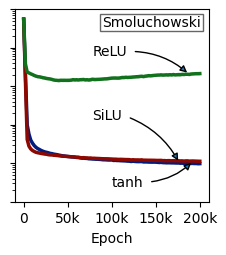

In [302]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
ylim: [0.0001, 10.0]
yticks: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
# yticklabels: ["0.0001", "0.0003", "0.001", "0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2.5

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  1:
    include: [{nn/act: silu}]
    ax.plot/color: blue
    ax.annotate/text: SiLU
    ax.annotate/xytext: [0.4, 0.43]
    ax.annotate/xy: [0.85, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
  2:
    include: [{nn/act: tanh}]
    ax.plot/color: red
    ax.annotate/text: "tanh"
    ax.annotate/xytext: [0.5, 0.08]
    ax.annotate/xy: [0.92, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  4:
    include: [{nn/act: relu}]
    ax.plot/color: green
    ax.annotate/text: ReLU
    ax.annotate/xytext: [0.4, 0.76]
    ax.annotate/xy: [0.9, null]
    arrowprops/relpos: [1.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_smol['data'][16]

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.45, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/09_mse_vs_epoch_act_bts.pdf', bbox_inches="tight")

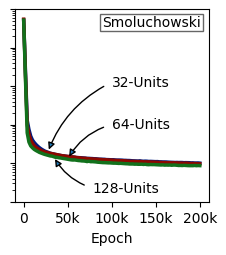

In [303]:
mpldict = yaml.safe_load("""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
ylim: [0.0001, 10.0]
yticks: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2.5

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null

elements:
  1:
    include: [{nn/width: 32}]
    ax.plot/color: blue
    ax.annotate/text: "32-Units"
    ax.annotate/xytext: [0.5, 0.6]
    ax.annotate/xy: [0.17, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  2:
    include: [{nn/width: 64}]
    ax.plot/color: red
    ax.annotate/text: "64-Units"
    ax.annotate/xytext: [0.5, 0.38]
    ax.annotate/xy: [0.28, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/shrinkB: 0.0
    arrowprops/connectionstyle: "arc3,rad=+0.2"
  4:
    include: [{nn/width: 128}]
    ax.plot/color: green
    ax.annotate/text: "128-Units"
    ax.annotate/xytext: [0.4, 0.05]
    ax.annotate/xy: [0.2, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_smol['data'][15]

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.45, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/10_mse_vs_epoch_width_bts.pdf', bbox_inches="tight")

#### Figure Batch 4: Delayed Targeting

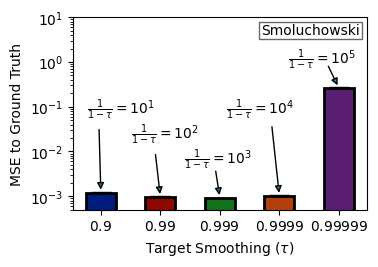

In [316]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Target Smoothing ($\\tau$)
xlabel: Target Smoothing ($\\tau$)
ylabel: MSE to Ground Truth
figsize: [3.8, 2.5]
elements:
  $0.9$:
    include: [{trg/tau: 0.9}]
    ax.bar/color: blue
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^1$
    ax.annotate/xytext: [0.05, 0.5]
    arrowprops/relpos: [0.17, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.99$:
    include: [{trg/tau: 0.99}]
    ax.bar/color: red
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^2$
    ax.annotate/xytext: [0.2, 0.37]
    arrowprops/relpos: [0.32, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.999$:
    include: [{trg/tau: 0.999}]
    ax.bar/color: green
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^3$
    ax.annotate/xytext: [0.38, 0.24]
    arrowprops/relpos: [0.46, 0.0]
    arrowprops/shrinkA: 0
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.9999$:
    include: [{trg/tau: 0.9999}]
    ax.bar/color: orange
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^4$
    ax.annotate/xytext: [0.52, 0.5]
    arrowprops/relpos: [0.67, 0.0]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
  $0.99999$:
    include: [{trg/tau: 0.99999}]
    ax.bar/color: purple
    ax.annotate/text: $\\frac{1}{1-\\tau}=10^5$
    ax.annotate/xytext: [0.73, 0.76]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/relpos: [0.6, 0.2]
    arrowprops/shrinkA: 0
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_smol['data'][10]

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.64, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/11_mse_vs_tau.pdf', bbox_inches="tight")

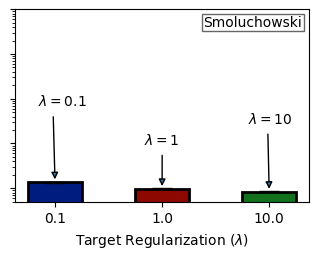

In [322]:
mpldict = yaml.safe_load("""
kind: bar
xcol: Target Regularization ($\\lambda$)
xlabel: Target Regularization ($\\lambda$)
ylabel: MSE to Ground Truth

# Remove the following two lines for bringing back ylabel and ticks
yticklabels: []
ylabel: null
figsize: [3.8, 2.5]

elements:
  0.1:
    include: [{trg/reg/w: 0.1}]
    ax.bar/color: blue
    ax.annotate/text: $\\lambda=0.1$
    ax.annotate/xytext: [0.08, 0.5]
    arrowprops/relpos: [0.3, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  1:
    include: [{trg/reg/w: 1.0}]
    ax.bar/color: red
    ax.annotate/text: $\\lambda=1$
    ax.annotate/xytext: [0.44, 0.3]
    arrowprops/relpos: [0.5, 0.0]
    arrowprops/connectionstyle: "arc3,rad=0.0"
  10:
    include: [{trg/reg/w: 10.0}]
    ax.bar/color: green
    ax.annotate/text: $\\lambda=10$
    ax.annotate/xytext: [0.79, 0.41]
    arrowprops/relpos: [0.45, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.0"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_smol['data'][11]

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.64, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/12_mse_vs_lambda.pdf', bbox_inches="tight")

#### Figure Batch 5: Learning Rate

In [15]:
smrypath = f'../summary/21_smoluchowski.h5'
get_h5du(smrypath, verbose=True, detailed=False)
data = load_h5data(smrypath)
data_ = hie2deep(data, maxdepth=1)
data_lr_ = data_['mselr']
hpdf_lr = data_lr_['hp']
statdf_lr = data_lr_['stat']

ymlpath = f'{workdir}/56_smoluchowski.yml'
data_lr = [('Standard Training', hpdf_lr, statdf_lr)]

dashdata_lr = get_dashdata(data_lr, ymlpath, write_yml=False)

smoldir = f'{suppdir}/02_smoluchowski'
! mkdir -p {smoldir}

Disk usage for "../summary/21_smoluchowski.h5"
mselr/hp                                                                          4.454 MB
bts/hp                                                                           14.454 MB
mse/hp                                                                           21.423 MB
bts/stat                                                                         31.512 MB
mselr/stat                                                                        9.696 MB
mse/stat                                                                         35.552 MB
------------------------------------------------------------------------------------------
Total                                                                             0.117 GB


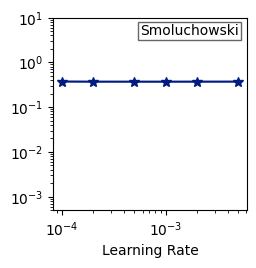

In [328]:
mpldict = yaml.safe_load("""
kind: line
xcol: opt/lr
xlabel: Learning Rate
xscale: log
ax.plot/marker: '*'
ax.plot/markersize: 7
# ylim: [0.1, 10]

# Remove the following two lines for bringing back ylabel and ticks
# xticks: [0.0001, 0.0003, 0.001, 0.003]
# xticklabels: ["$10^{-4}$", "$3 \\\\times 10^{-4}$", "$10^{-3}$", "$3 \\\\times 10^{-3}$"]
xticks: [0.0001, 0.001]
xticklabels: ["$10^{-4}$", "$10^{-3}$"]
ylabel: null

elements:
  Standard:
    # include: [{trg/btstrp: false, pts/detspc: false}]
    ax.plot/color: blue
    # ax.annotate/text: "Standard (N=1)"
    # ax.annotate/xytext: [0.1, 0.8]
    # ax.annotate/xy: [0.85, null]
    # arrowprops/relpos: [1.0, 0.6]
    # arrowprops/connectionstyle: "arc3,rad=-0.2"
""")

aggdf = dashdata_lr['data'][1][2].copy(deep=True)
fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.45, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/13_mse_vs_lr_std.pdf', bbox_inches="tight")

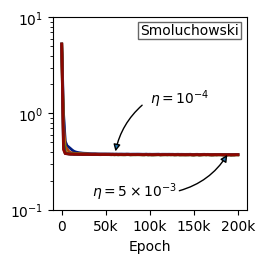

In [329]:
mpldict = yaml.safe_load(r"""
kind: line
xcol: Epoch
xlabel: Epoch
smry/sel: null
smry/cri: null
ylim: [0.1, 10]
# yticks: [0.003, 0.01, 0.03]
# yticklabels: ["0.003", "0.01", "0.03"]
xticks: [0, 50000, 100000, 150000, 200000]
xticklabels: [0, 50k, 100k, 150k, 200k]
ax.plot/lw: 2
ylabel: null
elements:
  0.005:
    include: [{opt/lr: 0.005}]
    ax.plot/color: red
    ax.annotate/text: "$\\eta=5\\times 10^{-3}$"
    ax.annotate/xytext: [0.2, 0.07]
    ax.annotate/xy: [0.90, null]
    arrowprops/relpos: [1.0, 0.5]
    bbox/pad: 90
    bbox/facecolor: none
    bbox/edgecolor: none
    arrowprops/shrinkB: 0
    arrowprops/connectionstyle: "arc3,rad=0.2"
  0.002: {include: [{opt/lr: 0.002}], ax.plot/color: purple}
  0.001: {include: [{opt/lr: 0.001}], ax.plot/color: green}
  0.0005: {include: [{opt/lr: 0.0005}], ax.plot/color: yellow}
  0.0002: {include: [{opt/lr: 0.0002}], ax.plot/color: orange}
  0.0001:
    include: [{opt/lr: 0.0001}]
    ax.plot/color: blue
    ax.annotate/text: "$\\eta=10^{-4}$"
    ax.annotate/xytext: [0.5, 0.55]
    ax.annotate/xy: [0.32, null]
    arrowprops/relpos: [0.0, 0.5]
    arrowprops/connectionstyle: "arc3,rad=0.2"
""")

method, ablname, aggdf, hpcols, stcols, _ = dashdata_lr['data'][1]

fig, ax = draw_matplotlib({**mplglbls_smol, **mpldict}, aggdf)
bbox = dict(facecolor='none', edgecolor='black', pad=1.3, alpha=0.6)
ax.text(0.45, 0.91, 'Smoluchowski', transform=ax.transAxes, bbox=bbox)

fig.savefig(f'{smoldir}/14_mse_vs_epoch_lr_std.pdf', bbox_inches="tight")